# Andrei Aiurov

Regression analysis of the **Gross Domestic Product** of the EU countries in **2021**.

---

# 1) Data preprocessing

Importing libraries.

In [1]:
library(eurostat)
library(cowplot)
library(ggthemes)
library(sf)
library(giscoR)
library(ggplot2)
library(ggpubr)
library(scales)
library(cowplot)
library(tidyverse)
library(leaflet)
library(conflicted)
library(sets)
library(geojsonio)
library(viridis)
library(RColorBrewer)
library(plotly)
library(car)
library(lmtest)
library(MASS)

Warning message in system("timedatectl", intern = TRUE):
“running command 'timedatectl' had status 1”



Attaching package: ‘ggthemes’


The following object is masked from ‘package:cowplot’:

    theme_map


Linking to GEOS 3.10.2, GDAL 3.4.1, PROJ 8.2.1; sf_use_s2() is TRUE


Attaching package: ‘ggpubr’


The following object is masked from ‘package:cowplot’:

    get_legend


── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ lubridate 1.9.3     ✔ tibble    3.2.1
✔ purrr     1.0.2     ✔ tidyr     1.3.1
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ readr::col_factor() masks scales::col_factor()
✖ purrr::discard()    masks scales::discard()
✖ dplyr::filter()     masks stats::filter()
✖ dplyr::lag()        masks stats::lag()
✖ lubridate::stamp()  masks cowplot::stamp()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
Registered S3 method overwritten by 'geojsonsf':
  method        from   


```

Loading main dataset and removing unimportant columns.

In [2]:
conflicts_prefer(geojsonio::`%>%`);

df <- get_eurostat(id = "nama_10_pc")

df <- df[df$na_item == "B1GQ" & df$unit == "CP_EUR_HAB" & df$TIME_PERIOD == "2021-01-01",]

df$freq <- NULL
df$na_item <- NULL
df$unit <- NULL
df$TIME_PERIOD <- NULL

df <- df %>%
       rename(gdp = values)

[conflicted] Will prefer geojsonio::`%>%` over any other package.
Warning message in get_eurostat(id = "nama_10_pc"):
“You have no access to ec.europe.eu.
      Please check your connection and/or review your proxy settings”
Table nama_10_pc cached at /tmp/RtmpZeU96o/eurostat/abfe6fc246eebdd7e6375e2b5b835bcf.rds



```

Loading names and information for plotting about 27 EU countries.

In [3]:
SHP_0 <- get_eurostat_geospatial(resolution = 10, 
                                 nuts_level = 0, 
                                 year = 2021);
EU27 <- eu_countries %>% 
  dplyr::filter(code != 'UK') %>% 
  select(geo = code, name);

SHP_27 <- SHP_0 %>% 
  select(geo = NUTS_ID, geometry) %>% 
  inner_join(EU27, by = "geo") %>% 
  arrange(geo) %>% 
  st_as_sf();

EU_27_set = sets::as.set(c(SHP_27$geo));

rm(SHP_0)

Extracting data using giscoR package, please report issues on https://github.com/rOpenGov/giscoR/issues

Cache management as per giscoR. see 'giscoR::gisco_get_nuts()'



```

Removing all non-EU countries.

In [4]:
df <- merge(EU27, df[c(df$geo) %in% EU_27_set, ], by = 'geo', )

```

EU countries sorted by `GDP`.

In [5]:
df[order(df$gdp, df$geo), ]

,geo,name,gdp
,<chr>,<chr>,<dbl>
3,BG,Bulgaria,10330
24,RO,Romania,12630
13,HR,Croatia,14880
22,PL,Poland,15100
14,HU,Hungary,15860
9,EL,Greece,17060
19,LV,Latvia,17710
27,SK,Slovakia,18430
17,LT,Lithuania,20110


```

Plotting `GDP` of EU countries.

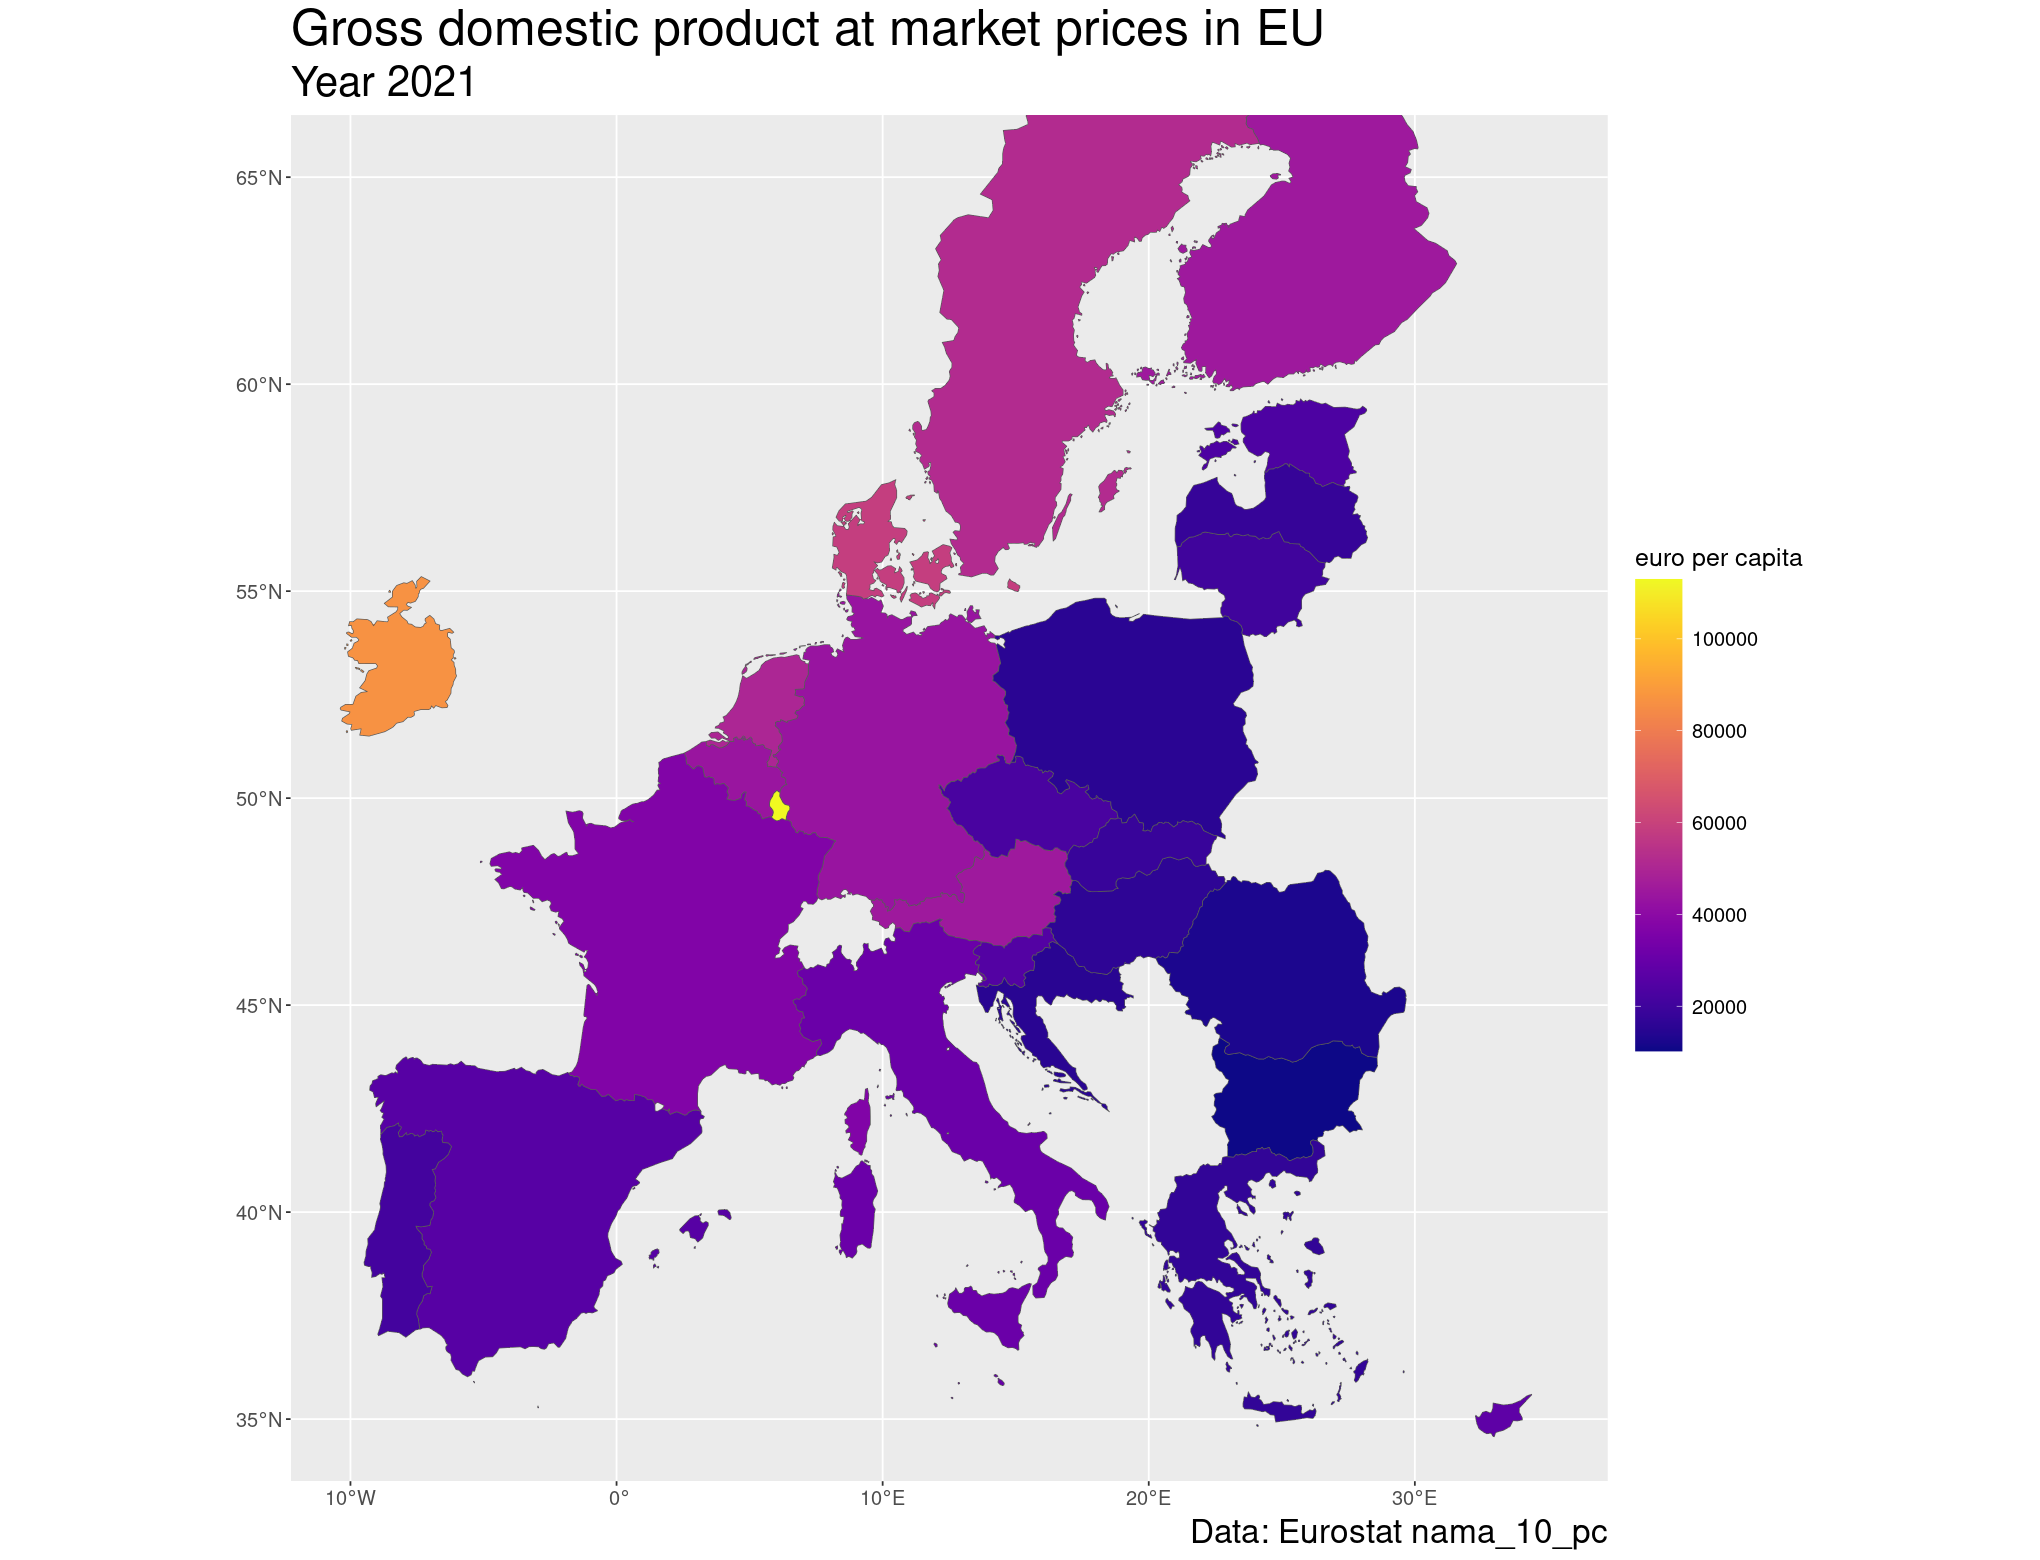

In [6]:
options(width=200, repr.plot.width=17, repr.plot.height=13);

df_tmp <- df %>% 
  inner_join(SHP_27, by = "geo") %>% 
  st_as_sf()

df_tmp %>%
  ggplot(aes(fill = gdp)) +
  labs(
    title = "Gross domestic product at market prices in EU",
    subtitle = "Year 2021",
    caption = "Data: Eurostat nama_10_pc",
  ) +
  theme (
    plot.title = element_text(size = 30),
    plot.subtitle = element_text(size = 25),
    plot.caption = element_text(size = 20),
    text = element_text(size = 15)
  ) +
  geom_sf() +
  scale_fill_viridis (
    discrete = FALSE, 
    option = 'C',
    name = "euro per capita",
    breaks = seq(from = 0, to = 120000, by = 20000),
    guide = guide_colorbar (
      barwidth = unit(1, "cm"),
      barheight = unit(10, "cm"),  
    )
  ) +
  scale_x_continuous(limits = c(-10, 35)) +
  scale_y_continuous(limits = c(35, 65))

rm(df_tmp)

---

# 2) Regressors choosing

In order to build the model correctly, we need to select regressors, that are able to predict the value of **GDP**. 

Generally, those factors can be divided into several categories:
- Economic
    - Interest rates
    - Inflation rates
    - Unemployent rates
    - Minimum wage
    - Currency
    - etc.
- Political
    - Political structure
    - Democracy / Autocracy / Totalitarianism
    - Participation in International Organizations (eg. EU, NATO)
    - etc.
- Social
    - Life expectancy
    - Life qualiity
    - Fertility
    - Education level
    - etc.
- Environmental
    - Access to sea
    - Neighbors
    - Country size
    - Mineral reources
    - etc.
- Historical
    - Year of EU enterance
    - etc.

```

### Minimun wage

First numerical regressor I decided to choose is `Minimum wage`.

 That value represents the minimum **monthly** wage in EU countries before tax (**gross wage**). Currency is **EURO**.

In [7]:
df_wage <- get_eurostat('earn_mw_cur')
df_wage <- df_wage[df_wage$TIME_PERIOD == "2021-01-01", ]
df_wage <- df_wage[df_wage$geo %in% EU_27_set, ]
df_wage <- df_wage[df_wage$currency == "EUR", ]
df_wage$freq <- NULL
df_wage$currency <- NULL
df_wage$TIME_PERIOD <- NULL

# Minimum wages for Austria and Cyprus are 1500 and 1000 euro respectively 
df_wage[df$geo == 'AT',]$values = 1500
df_wage[df$geo == 'CY',]$values = 1000

# Denmark, Finland, Italy and Sweden do not have fixed minimum wage. I used approximations
# https://denmarkexpat.com/minimum-wage-denmark/#:~:text=No%20law%20in%20Denmark%20mandates,bargaining%20agreements%20in%20each%20sector.&text=Nonetheless%2C%20employers%20and%20companies%20know,about%20DKK%20110%20per%20hour.
df_wage[df$geo == 'DK',]$values = 2230  # 17 000 DK = 2 230 EUR

# https://www.timecamp.com/average-salary/finland/
df_wage[df$geo == 'FI',]$values = 1800

# https://joinhorizons.com/countries/italy/hiring-employees/minimum-wage/#:~:text=wage%20in%20Italy%3F-,There%20is%20no%20statutory%20minimum%20wage%20in%20Italy.,the%20minimum%20wage%20in%20Italy%3F
df_wage[df$geo == 'IT',]$values = 1150

# sweden.se/life/society/taxes-in-sweden
df_wage[df$geo == 'SE',]$values = 1800 # 20 800 SK = 1 800 EUR

df_wage <- df_wage %>%
            rename(wage = values)

df <- merge(df_wage, df, by = 'geo', )
rm(df_wage)

Warning message in get_eurostat("earn_mw_cur"):
“You have no access to ec.europe.eu.
      Please check your connection and/or review your proxy settings”
Table earn_mw_cur cached at /tmp/RtmpZeU96o/eurostat/5cc146f333eec5076b8669f514282d5a.rds



```

Here is the dataset with new column `wage`.

In [8]:
df

geo,wage,name,gdp
<chr>,<dbl>,<chr>,<dbl>
AT,1500.00,Austria,45270
BE,1625.72,Belgium,43850
BG,332.34,Bulgaria,10330
CY,1000.00,Cyprus,27690
CZ,579.22,Czechia,22270
DE,1585.00,Germany,43480
DK,2230.00,Denmark,58590
EE,584.00,Estonia,23430
EL,758.33,Greece,17060


```

Correlation coefficient between `Minimum wage` and `GDP`.

In [9]:
cor(df$gdp, df$wage)

[1] 0.8598346

Those columns have strong positive linear dependence.

```

Visualizing dependence of `GDP` on `Minimum wage`.

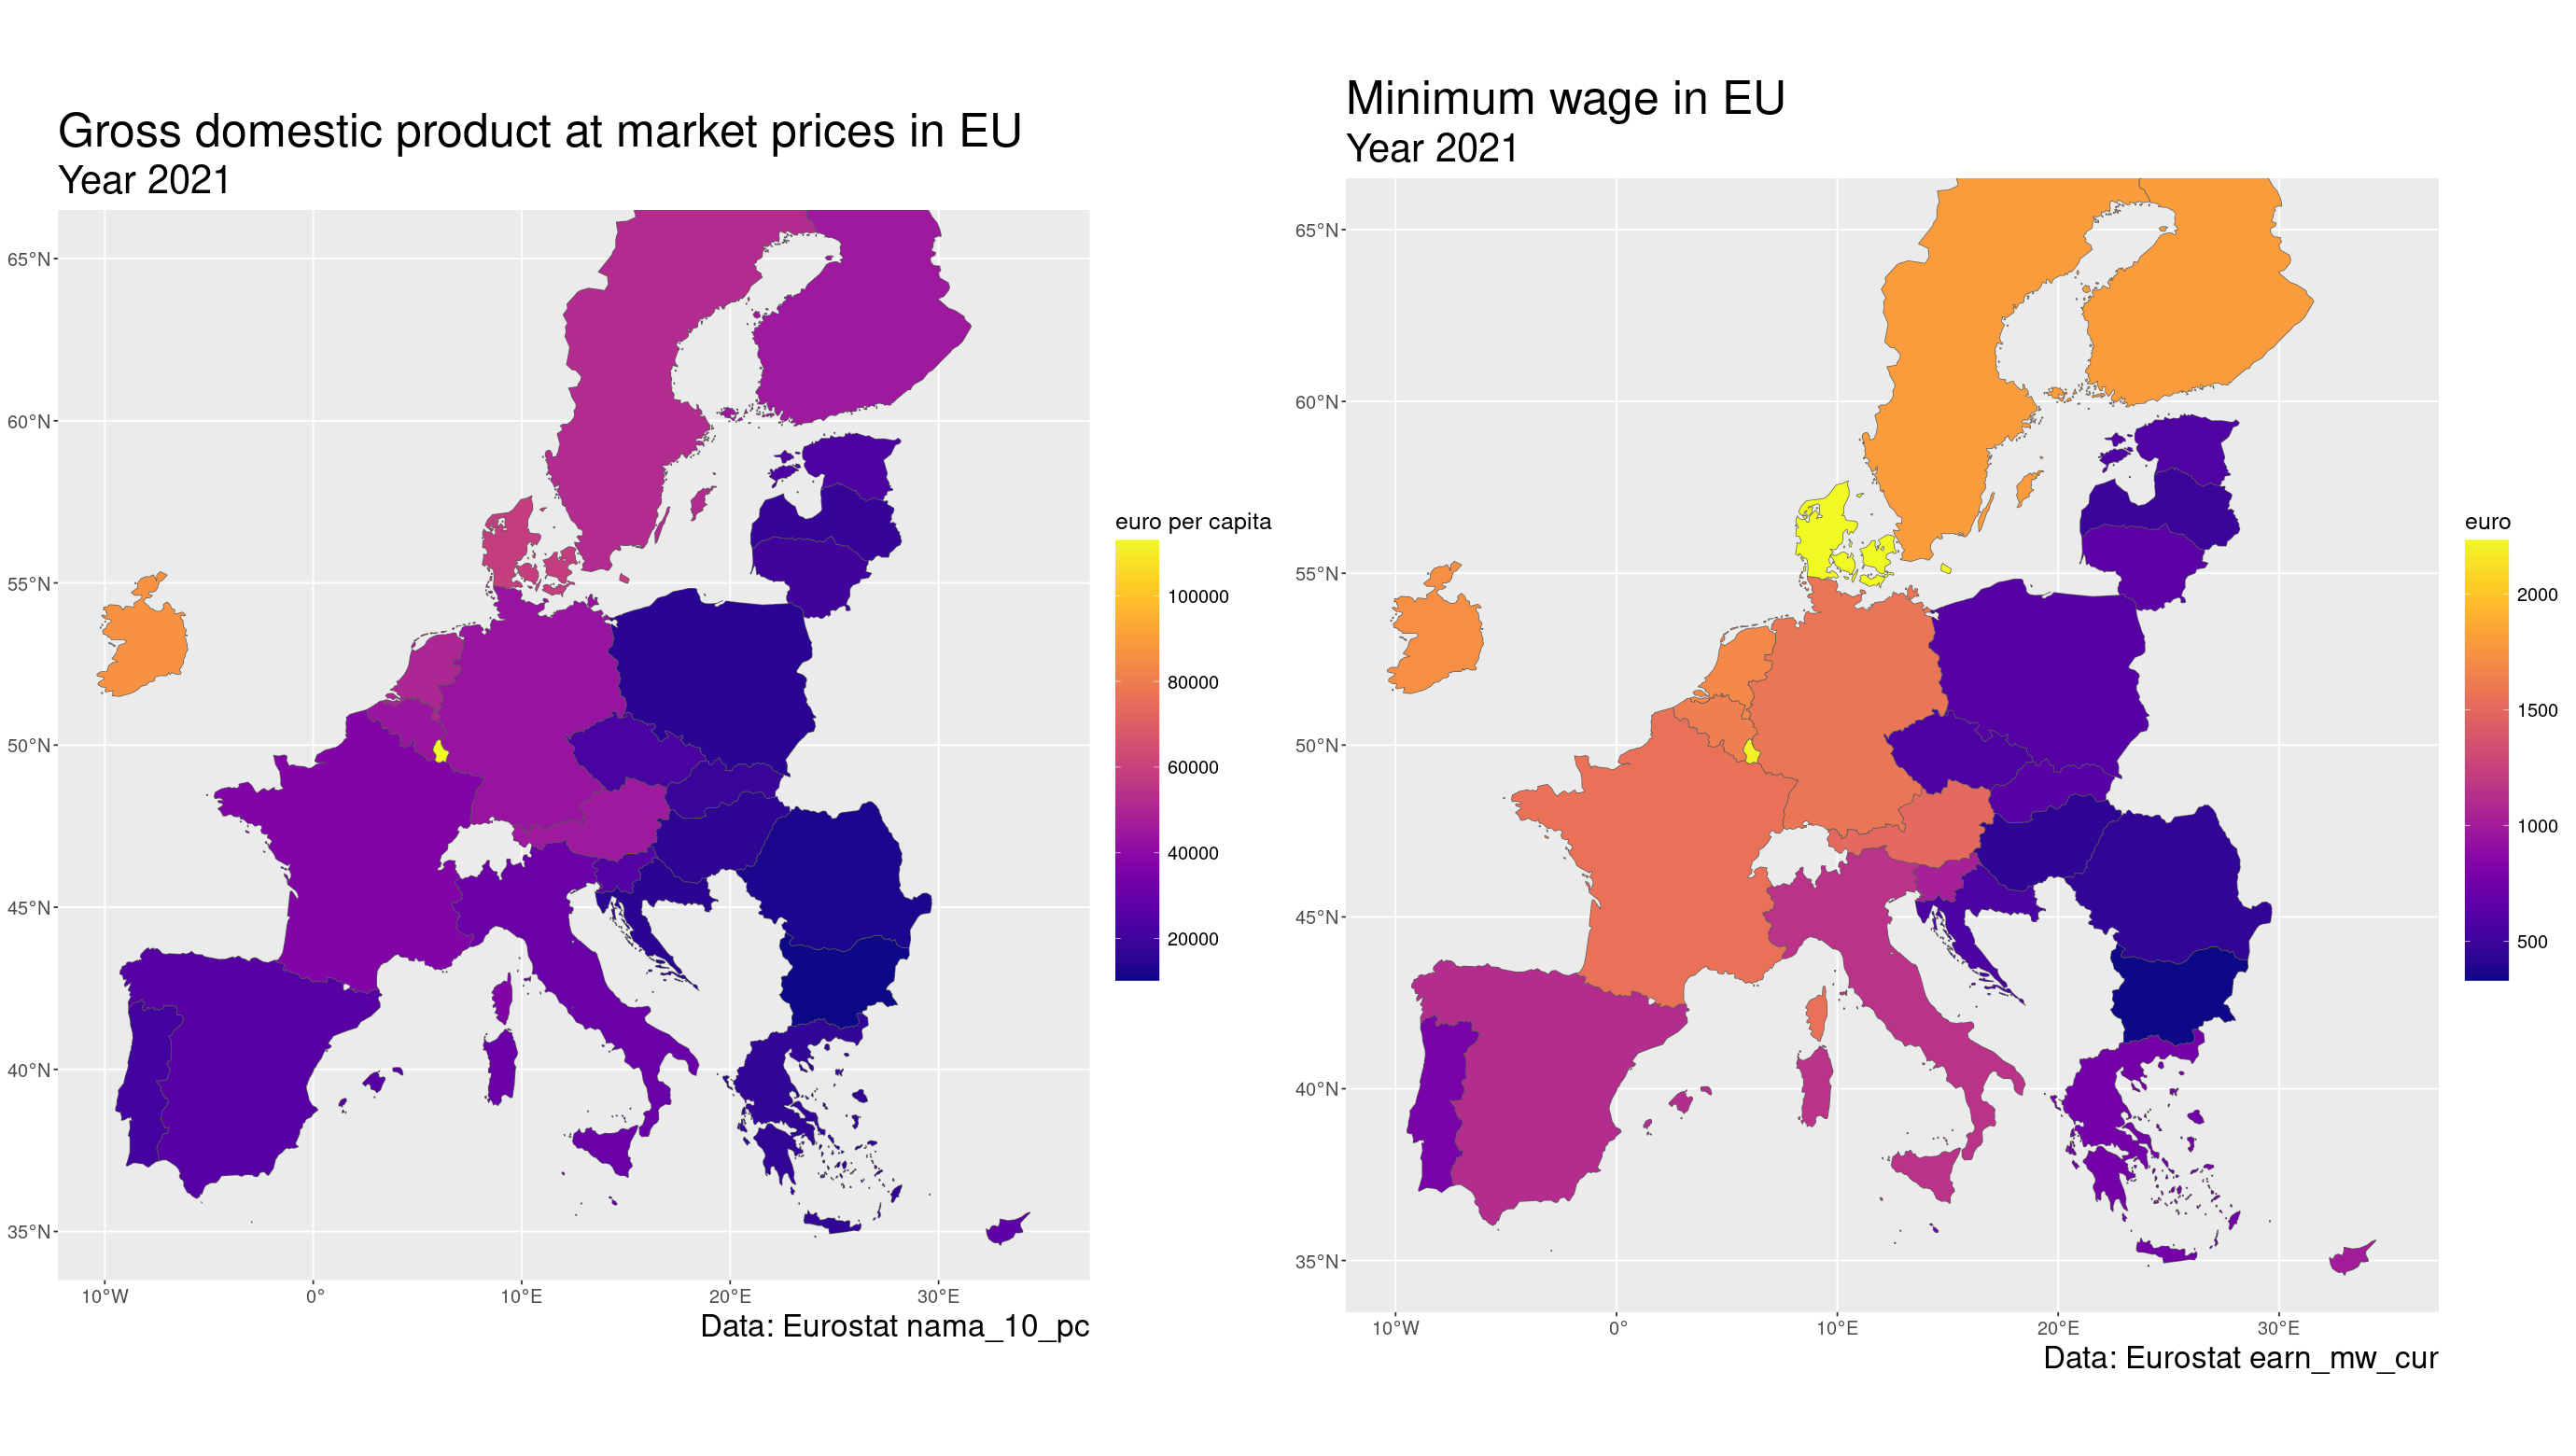

In [10]:
options(width=200, repr.plot.width=23, repr.plot.height=13);

df_tmp <- df %>% 
  inner_join(SHP_27, by = "geo") %>% 
  st_as_sf()

p1 <- df_tmp %>%
  ggplot(aes(fill = gdp)) +
  labs(
    title = "Gross domestic product at market prices in EU",
    subtitle = "Year 2021",
    caption = "Data: Eurostat nama_10_pc",
  ) +
  theme (
    plot.title = element_text(size = 30),
    plot.subtitle = element_text(size = 25),
    plot.caption = element_text(size = 20),
    text = element_text(size = 15)
  ) +
  geom_sf() +
  scale_fill_viridis (
    discrete = FALSE, 
    option = 'C',
    name = "euro per capita",
    breaks = seq(from = 0, to = 120000, by = 20000),
    guide = guide_colorbar (
      barwidth = unit(1, "cm"),
      barheight = unit(10, "cm"),  
    )
  ) +
  scale_x_continuous(limits = c(-10, 35)) +
  scale_y_continuous(limits = c(35, 65))


p2 <- df_tmp %>%
  ggplot(aes(fill = wage)) +
  labs(
    title = "Minimum wage in EU",
    subtitle = "Year 2021",
    caption = "Data: Eurostat earn_mw_cur",
  ) +
  theme (
    plot.title = element_text(size = 30),
    plot.subtitle = element_text(size = 25),
    plot.caption = element_text(size = 20),
    text = element_text(size = 15)
  ) +
  geom_sf() +
  scale_fill_viridis (
    discrete = FALSE, 
    option = 'C',
    name = "euro",
    breaks = seq(from = 0, to = 2500, by = 500),
    guide = guide_colorbar (
      barwidth = unit(1, "cm"),
      barheight = unit(10, "cm"),  
    )
  ) +
  scale_x_continuous(limits = c(-10, 35)) +
  scale_y_continuous(limits = c(35, 65))


ggarrange(p1, p2, ncol = 2, nrow = 1)

rm(df_tmp, p1, p2)

```

Quadratic regression model with `GDP` ~ `Minumum wage^2` formula.


Call:
lm(formula = gdp ~ I(wage^2), data = df)

Residuals:
   Min     1Q Median     3Q    Max 
-24588  -3835  -1998   1432  31810 

Coefficients:
             Estimate Std. Error t value Pr(>|t|)    
(Intercept) 1.237e+04  3.200e+03   3.865 0.000701 ***
I(wage^2)   1.424e-02  1.533e-03   9.290 1.39e-09 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 11330 on 25 degrees of freedom
Multiple R-squared:  0.7754,	Adjusted R-squared:  0.7664 
F-statistic:  86.3 on 1 and 25 DF,  p-value: 1.388e-09



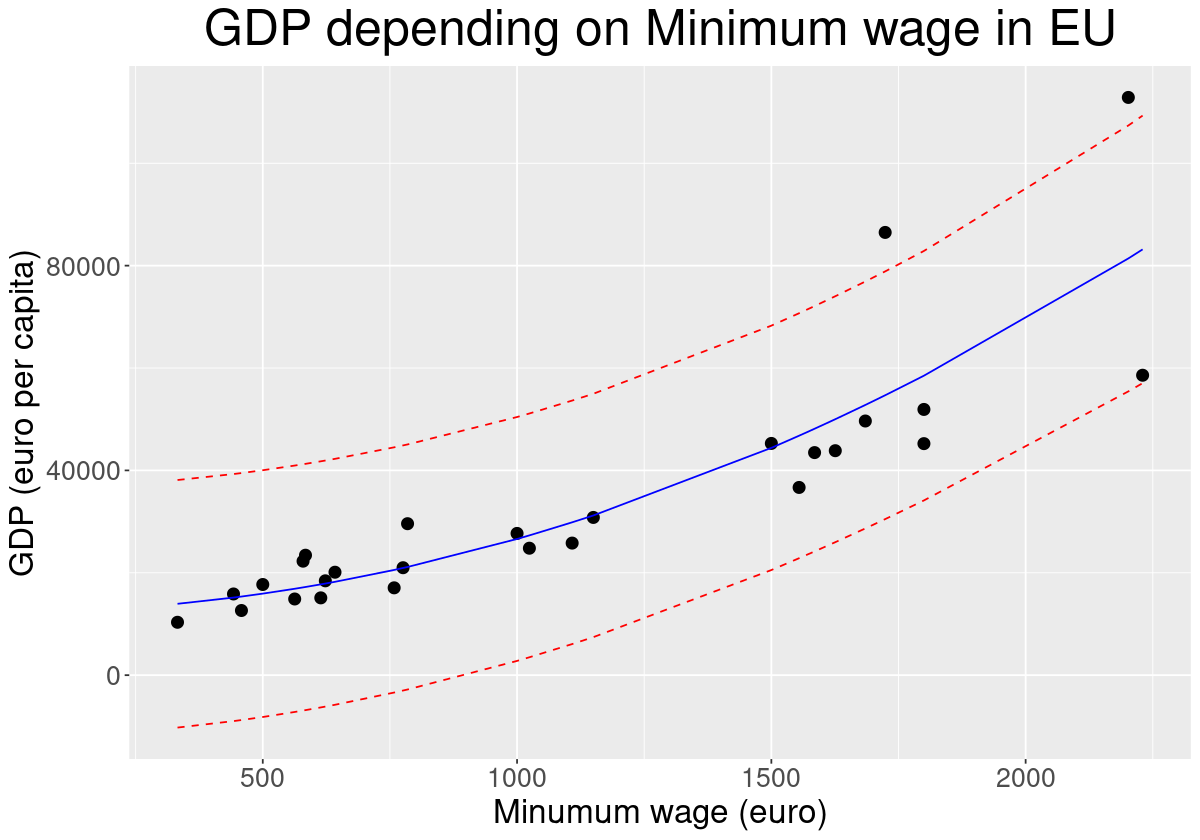

In [11]:
options(width=200, repr.plot.width=10, repr.plot.height=7);

# Fitting model
fit <- lm(formula = gdp ~ I(wage^2), data=df)
suppressWarnings({tmp <- predict(fit, interval="prediction")})
df_tmp <- cbind(df, tmp)

# Plotting main information about lm model
print(summary(fit))

# Plotting regression curve with confidential interval
ggplot(df_tmp, aes(y = gdp, x = wage)) +
xlab('Minumum wage (euro)') + 
ylab('GDP (euro per capita)') + 
ggtitle('GDP depending on Minimum wage in EU') + 
theme(plot.title = element_text(hjust = 0.5)) +
geom_point(size = 3) +
theme(
    text = element_text(size = 20),
    axis.title.x = element_text(size = 20),
    axis.title.y = element_text(size = 20),
    plot.title = element_text(size=30),
    ) +
geom_line(aes(y=fit), color="blue") +
geom_line(aes(y=lwr), color = "red", linetype = "dashed") +
geom_line(aes(y=upr), color = "red", linetype = "dashed")

rm(fit, df_tmp, tmp)

```

### Life expectancy

Second numerical regressor I have decided to choose is `Life epectancy`. 

That value represents expected lenght of life of EU citizens for both **males** and **females**. Life expectancy is represented in **years**.

In [15]:
df_life <- get_eurostat('demo_r_mlifexp')
df_life <- df_life[df_life$age == "Y1", ]
df_life <- df_life[df_life$TIME_PERIOD == "2021-01-01", ]
df_life <- df_life[df_life$geo %in% EU_27_set, ]
df_life <- df_life[df_life$sex == "T", ]

df_life$freq <- NULL
df_life$unit <- NULL
df_life$sex <- NULL
df_life$age <- NULL
df_life$TIME_PERIOD <- NULL

df_life <- df_life %>%
            rename(life_expectancy = values)

df <- merge(df_life, df, by = 'geo', )

rm(df_life)

Dataset query already saved in cache_list.json...

Reading cache file /tmp/RtmpZeU96o/eurostat/2cf8a509de46c2e7ae208fc380c55686.rds

Table  demo_r_mlifexp  read from cache file:  /tmp/RtmpZeU96o/eurostat/2cf8a509de46c2e7ae208fc380c55686.rds



```

Here is the dataset that contains new `life_expectancy` column.

In [16]:
df

geo,life_expectancy,wage,name,gdp
<chr>,<dbl>,<dbl>,<chr>,<dbl>
AT,80.5,1500.00,Austria,45270
BE,81.1,1625.72,Belgium,43850
BG,70.8,332.34,Bulgaria,10330
CY,80.5,1000.00,Cyprus,27690
CZ,76.4,579.22,Czechia,22270
DE,80.1,1585.00,Germany,43480
DK,80.7,2230.00,Denmark,58590
EE,76.3,584.00,Estonia,23430
EL,79.4,758.33,Greece,17060


```

Correlation coefficient between `Life expectancy` and `GDP`.

In [17]:
cor(df$gdp, df$life_expectancy)

[1] 0.6031494

Those columns have high correlation.

```

Visualizing dependence of `GDP` on `Life expectancy`.

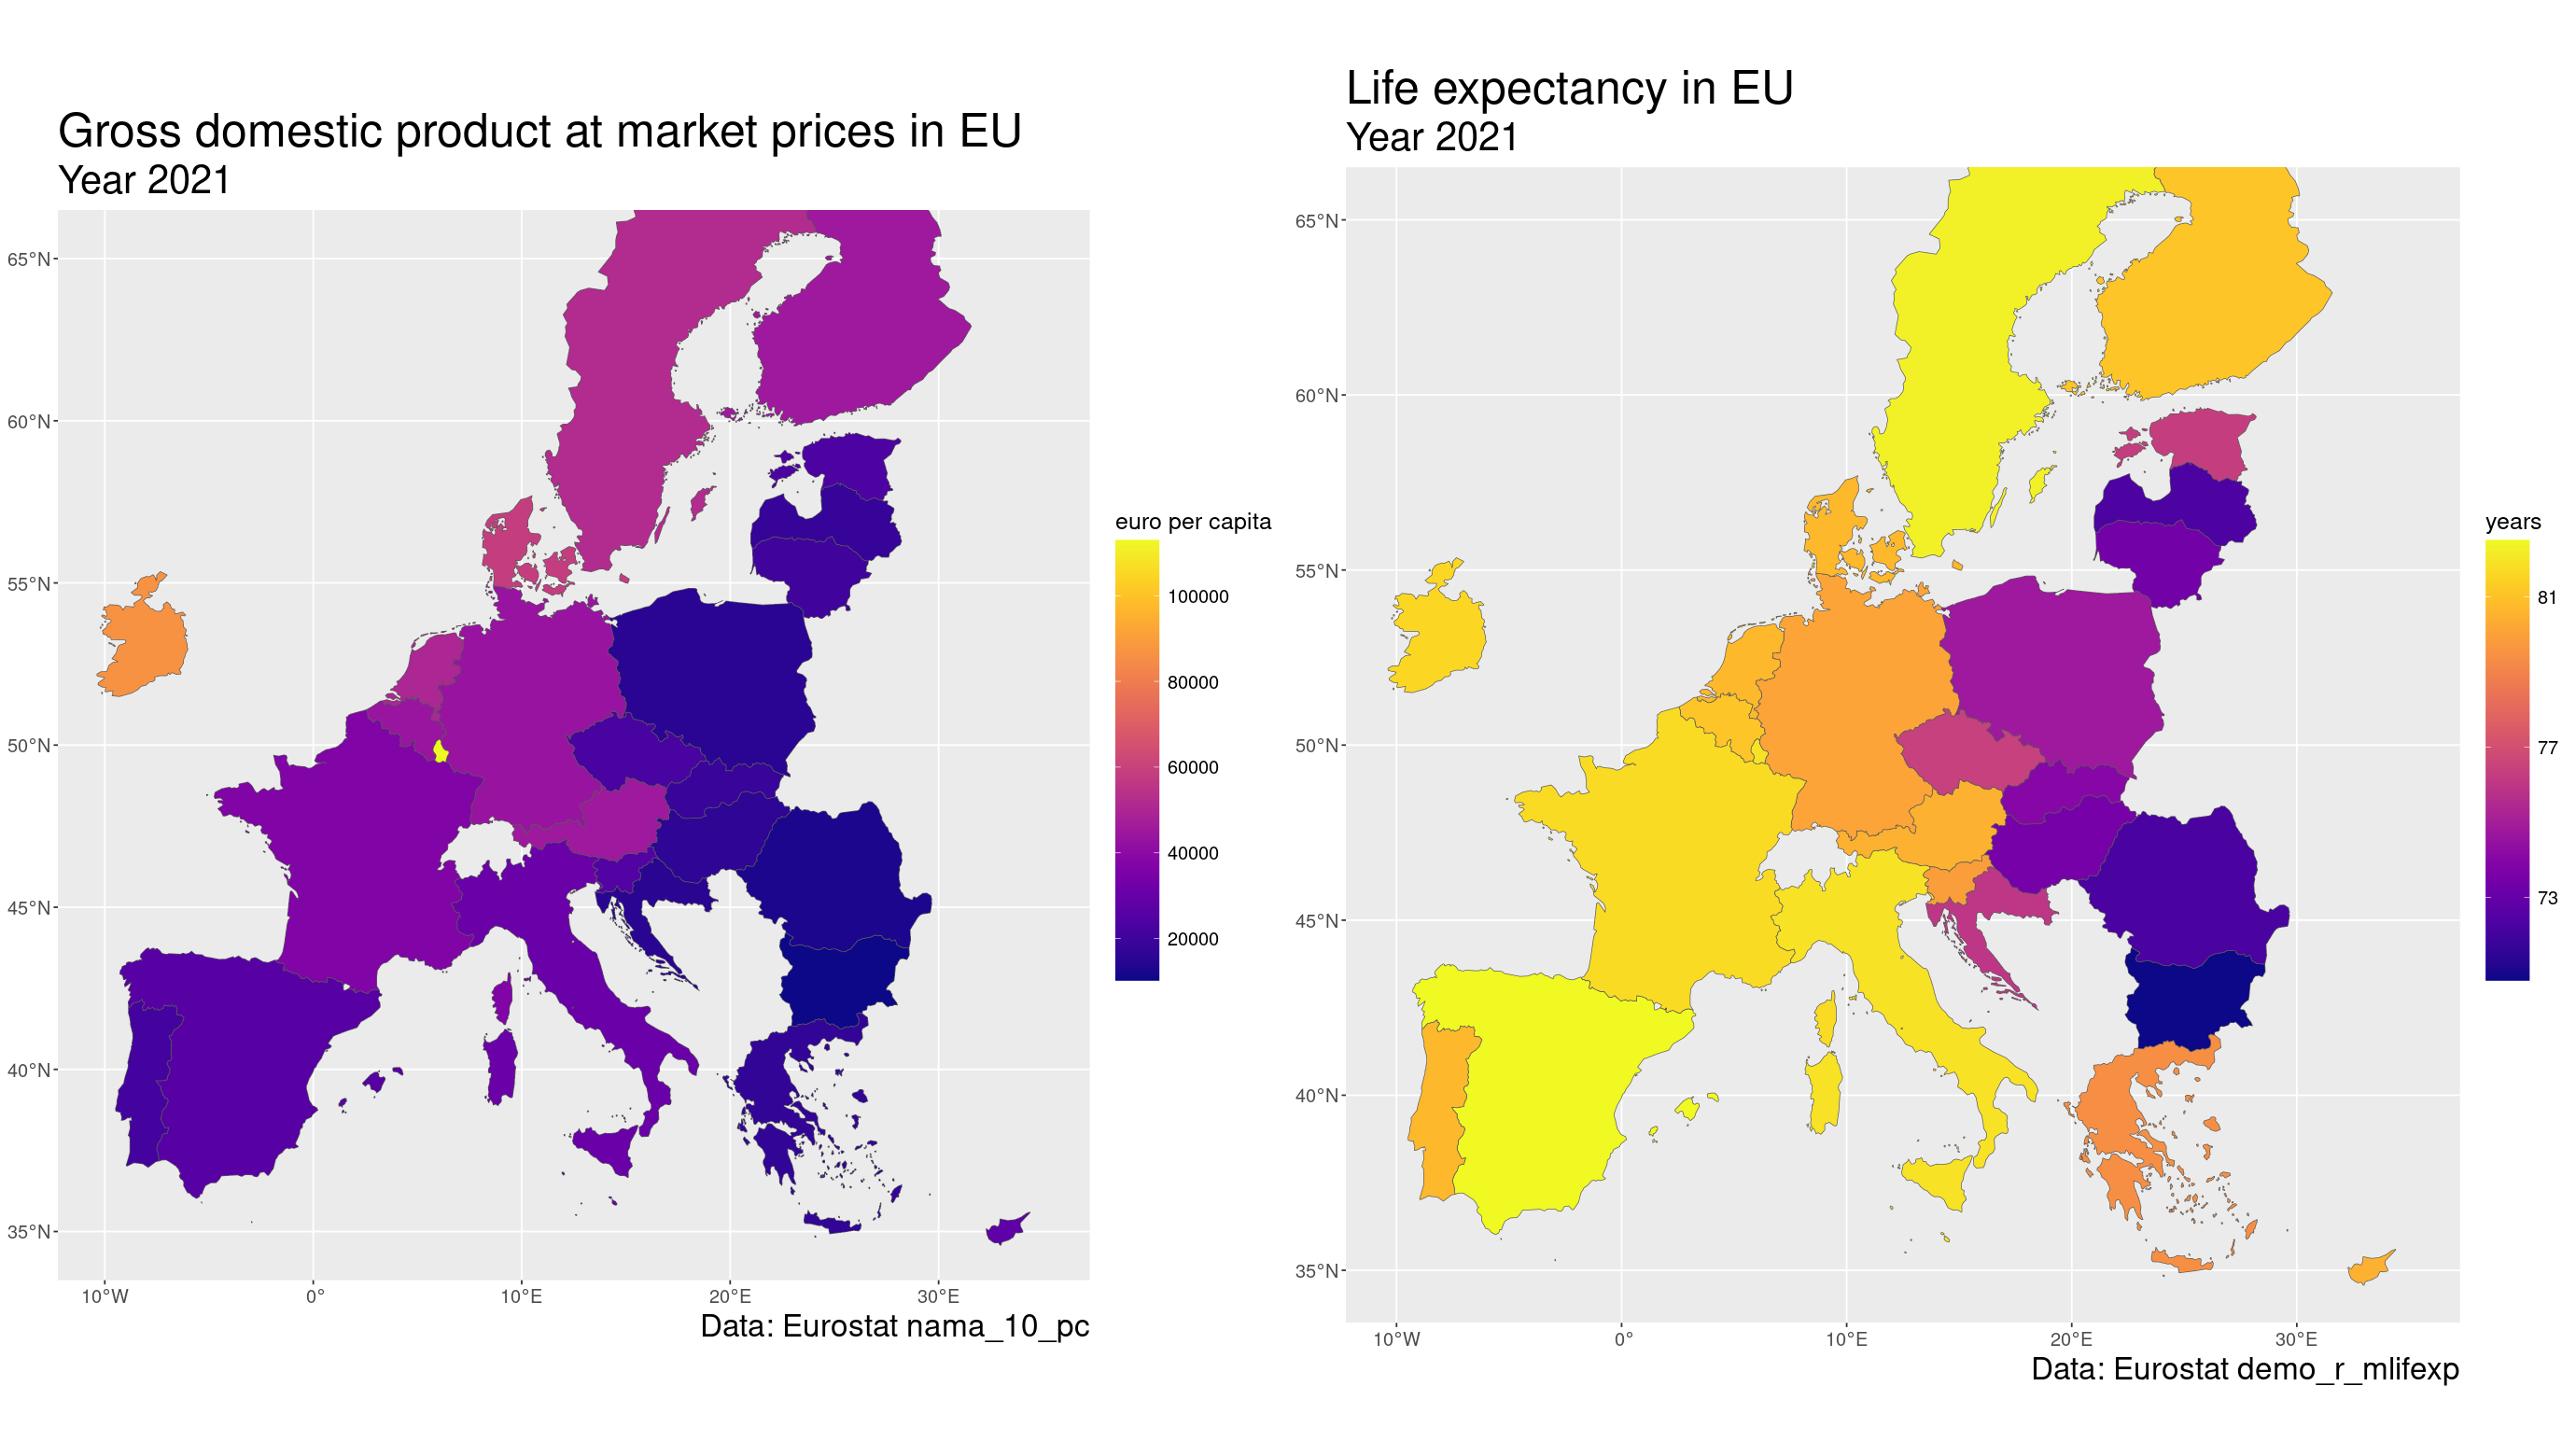

In [18]:
options(width=200, repr.plot.width=23, repr.plot.height=13);

df_tmp <- df %>% 
  inner_join(SHP_27, by = "geo") %>% 
  st_as_sf()

p1 <- df_tmp %>%
  ggplot(aes(fill = gdp)) +
  labs(
    title = "Gross domestic product at market prices in EU",
    subtitle = "Year 2021",
    caption = "Data: Eurostat nama_10_pc",
  ) +
  theme (
    plot.title = element_text(size = 30),
    plot.subtitle = element_text(size = 25),
    plot.caption = element_text(size = 20),
    text = element_text(size = 15)
  ) +
  geom_sf() +
  scale_fill_viridis (
    discrete = FALSE, 
    option = 'C',
    name = "euro per capita",
    breaks = seq(from = 0, to = 120000, by = 20000),
    guide = guide_colorbar (
      barwidth = unit(1, "cm"),
      barheight = unit(10, "cm"),  
    )
  ) +
  scale_x_continuous(limits = c(-10, 35)) +
  scale_y_continuous(limits = c(35, 65))


p2 <- df_tmp %>%
  ggplot(aes(fill = life_expectancy)) +
  labs(
    title = "Life expectancy in EU",
    subtitle = "Year 2021",
    caption = "Data: Eurostat demo_r_mlifexp",
  ) +
  theme (
    plot.title = element_text(size = 30),
    plot.subtitle = element_text(size = 25),
    plot.caption = element_text(size = 20),
    text = element_text(size = 15)
  ) +
  geom_sf() +
  scale_fill_viridis (
    discrete = FALSE, 
    option = 'C',
    name = "years",
    breaks = seq(from = 69, to = 85, by = 4),
    guide = guide_colorbar (
      barwidth = unit(1, "cm"),
      barheight = unit(10, "cm"),  
    )
  ) +
  scale_x_continuous(limits = c(-10, 35)) +
  scale_y_continuous(limits = c(35, 65))


ggarrange(p1, p2, ncol = 2, nrow = 1)

rm(df_tmp, p1, p2)

```

Quadratic regression model with `GDP` ~ `Life expectancy^2` formula.


Call:
lm(formula = gdp ~ I(life_expectancy^2), data = df)

Residuals:
   Min     1Q Median     3Q    Max 
-24012 -12011    556   4036  65473 

Coefficients:
                       Estimate Std. Error t value Pr(>|t|)    
(Intercept)          -1.175e+05  4.000e+04  -2.936 0.007030 ** 
I(life_expectancy^2)  2.458e+01  6.458e+00   3.806 0.000815 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 19020 on 25 degrees of freedom
Multiple R-squared:  0.3668,	Adjusted R-squared:  0.3415 
F-statistic: 14.48 on 1 and 25 DF,  p-value: 0.0008149



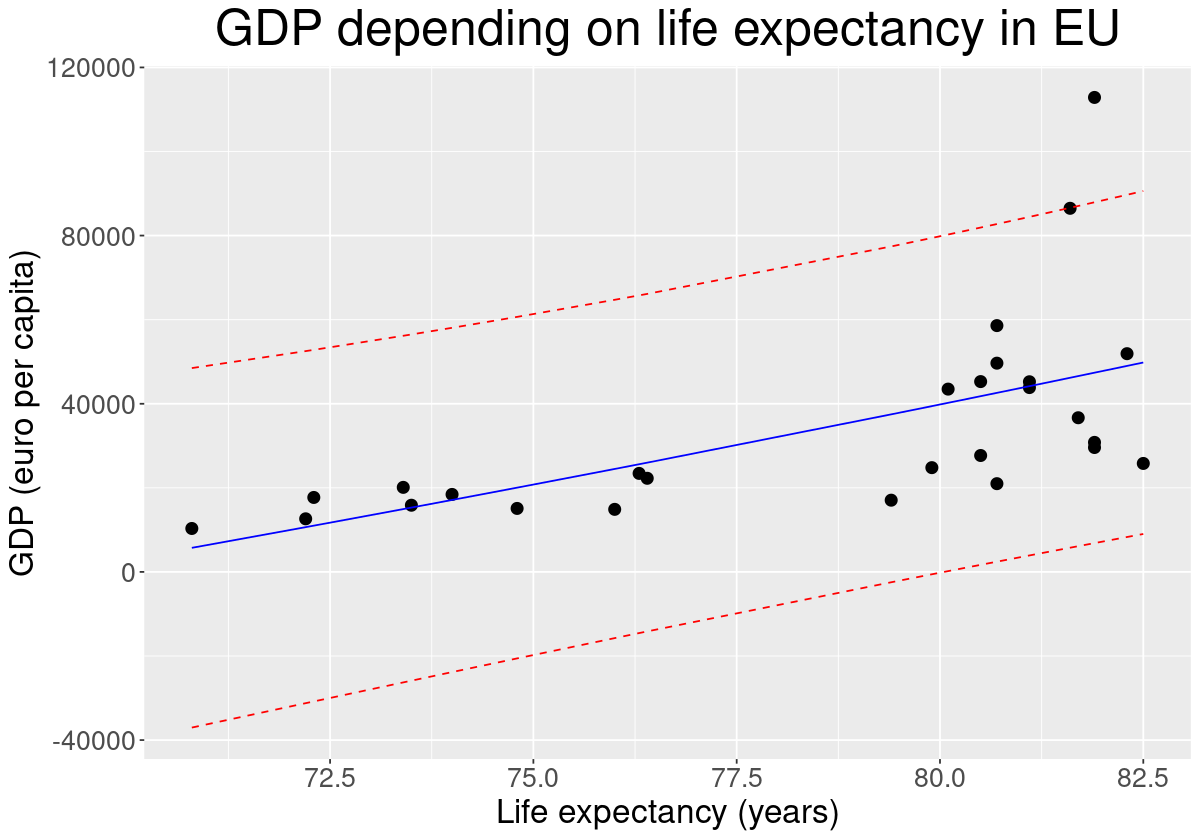

In [19]:
options(width=200, repr.plot.width=10, repr.plot.height=7);

# Fitting model
fit <- lm(formula = gdp ~ I(life_expectancy^2), data=df)
suppressWarnings({tmp <- predict(fit, interval="prediction")})
df_tmp <- cbind(df, tmp)

# Plotting main information about lm model
print(summary(fit))

# Plotting regression curve with confidential interval
ggplot(df_tmp, aes(y = gdp, x = life_expectancy)) +
xlab('Life expectancy (years)') + 
ylab('GDP (euro per capita)') + 
ggtitle('GDP depending on life expectancy in EU') + 
theme(plot.title = element_text(hjust = 0.5)) +
geom_point(size = 3) +
theme(
    text = element_text(size = 20),
    axis.title.x = element_text(size = 20),
    axis.title.y = element_text(size = 20),
    plot.title = element_text(size=30),
    ) +
geom_line(aes(y=fit), color="blue") +
geom_line(aes(y=lwr), color = "red", linetype = "dashed") +
geom_line(aes(y=upr), color = "red", linetype = "dashed")

rm(fit, df_tmp, tmp)

```

### Education level

Last numerical regressor I have decided to choose is `Education level`. 

That value represents **percentage** of population that have successfully completed **tertiary** (5-8 according to ISCED 2011) level education (Short-cycle, Bachelor, Master, Doctor and their equivalents).

In [20]:
df_edu <- get_eurostat('edat_lfse_03')
df_edu <- df_edu[df_edu$age == "Y15-64", ]
df_edu <- df_edu[df_edu$TIME_PERIOD == "2021-01-01", ]
df_edu <- df_edu[df_edu$geo %in% EU_27_set, ]
df_edu <- df_edu[df_edu$sex == "T", ]
df_edu <- df_edu[df_edu$isced11 == "ED5-8", ]
df_edu$freq <- NULL
df_edu$unit <- NULL
df_edu$sex <- NULL
df_edu$age <- NULL
df_edu$TIME_PERIOD <- NULL
df_edu$isced11 <- NULL

df_edu <- df_edu %>%
             rename(edu = values)

df <- merge(df_edu, df, by = 'geo', )

rm(df_edu)

Table edat_lfse_03 cached at /tmp/RtmpZeU96o/eurostat/572f67dfaa9c0e37f0d92fe9962e3659.rds



```

Here is the dataset with new `edu` regressor.

In [21]:
df

geo,edu,life_expectancy,wage,name,gdp
<chr>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>
AT,31.8,80.5,1500.00,Austria,45270
BE,39.7,81.1,1625.72,Belgium,43850
BG,25.9,70.8,332.34,Bulgaria,10330
CY,41.9,80.5,1000.00,Cyprus,27690
CZ,23.4,76.4,579.22,Czechia,22270
DE,28.0,80.1,1585.00,Germany,43480
DK,34.8,80.7,2230.00,Denmark,58590
EE,36.0,76.3,584.00,Estonia,23430
EL,30.1,79.4,758.33,Greece,17060


```

Correlation coefficient between `Education level` and `GDP`.

In [22]:
cor(df$gdp, df$edu)

[1] 0.6308358

Those columns are highly correlated.

```

Visualizing dependence of `GDP` on `Education level`.

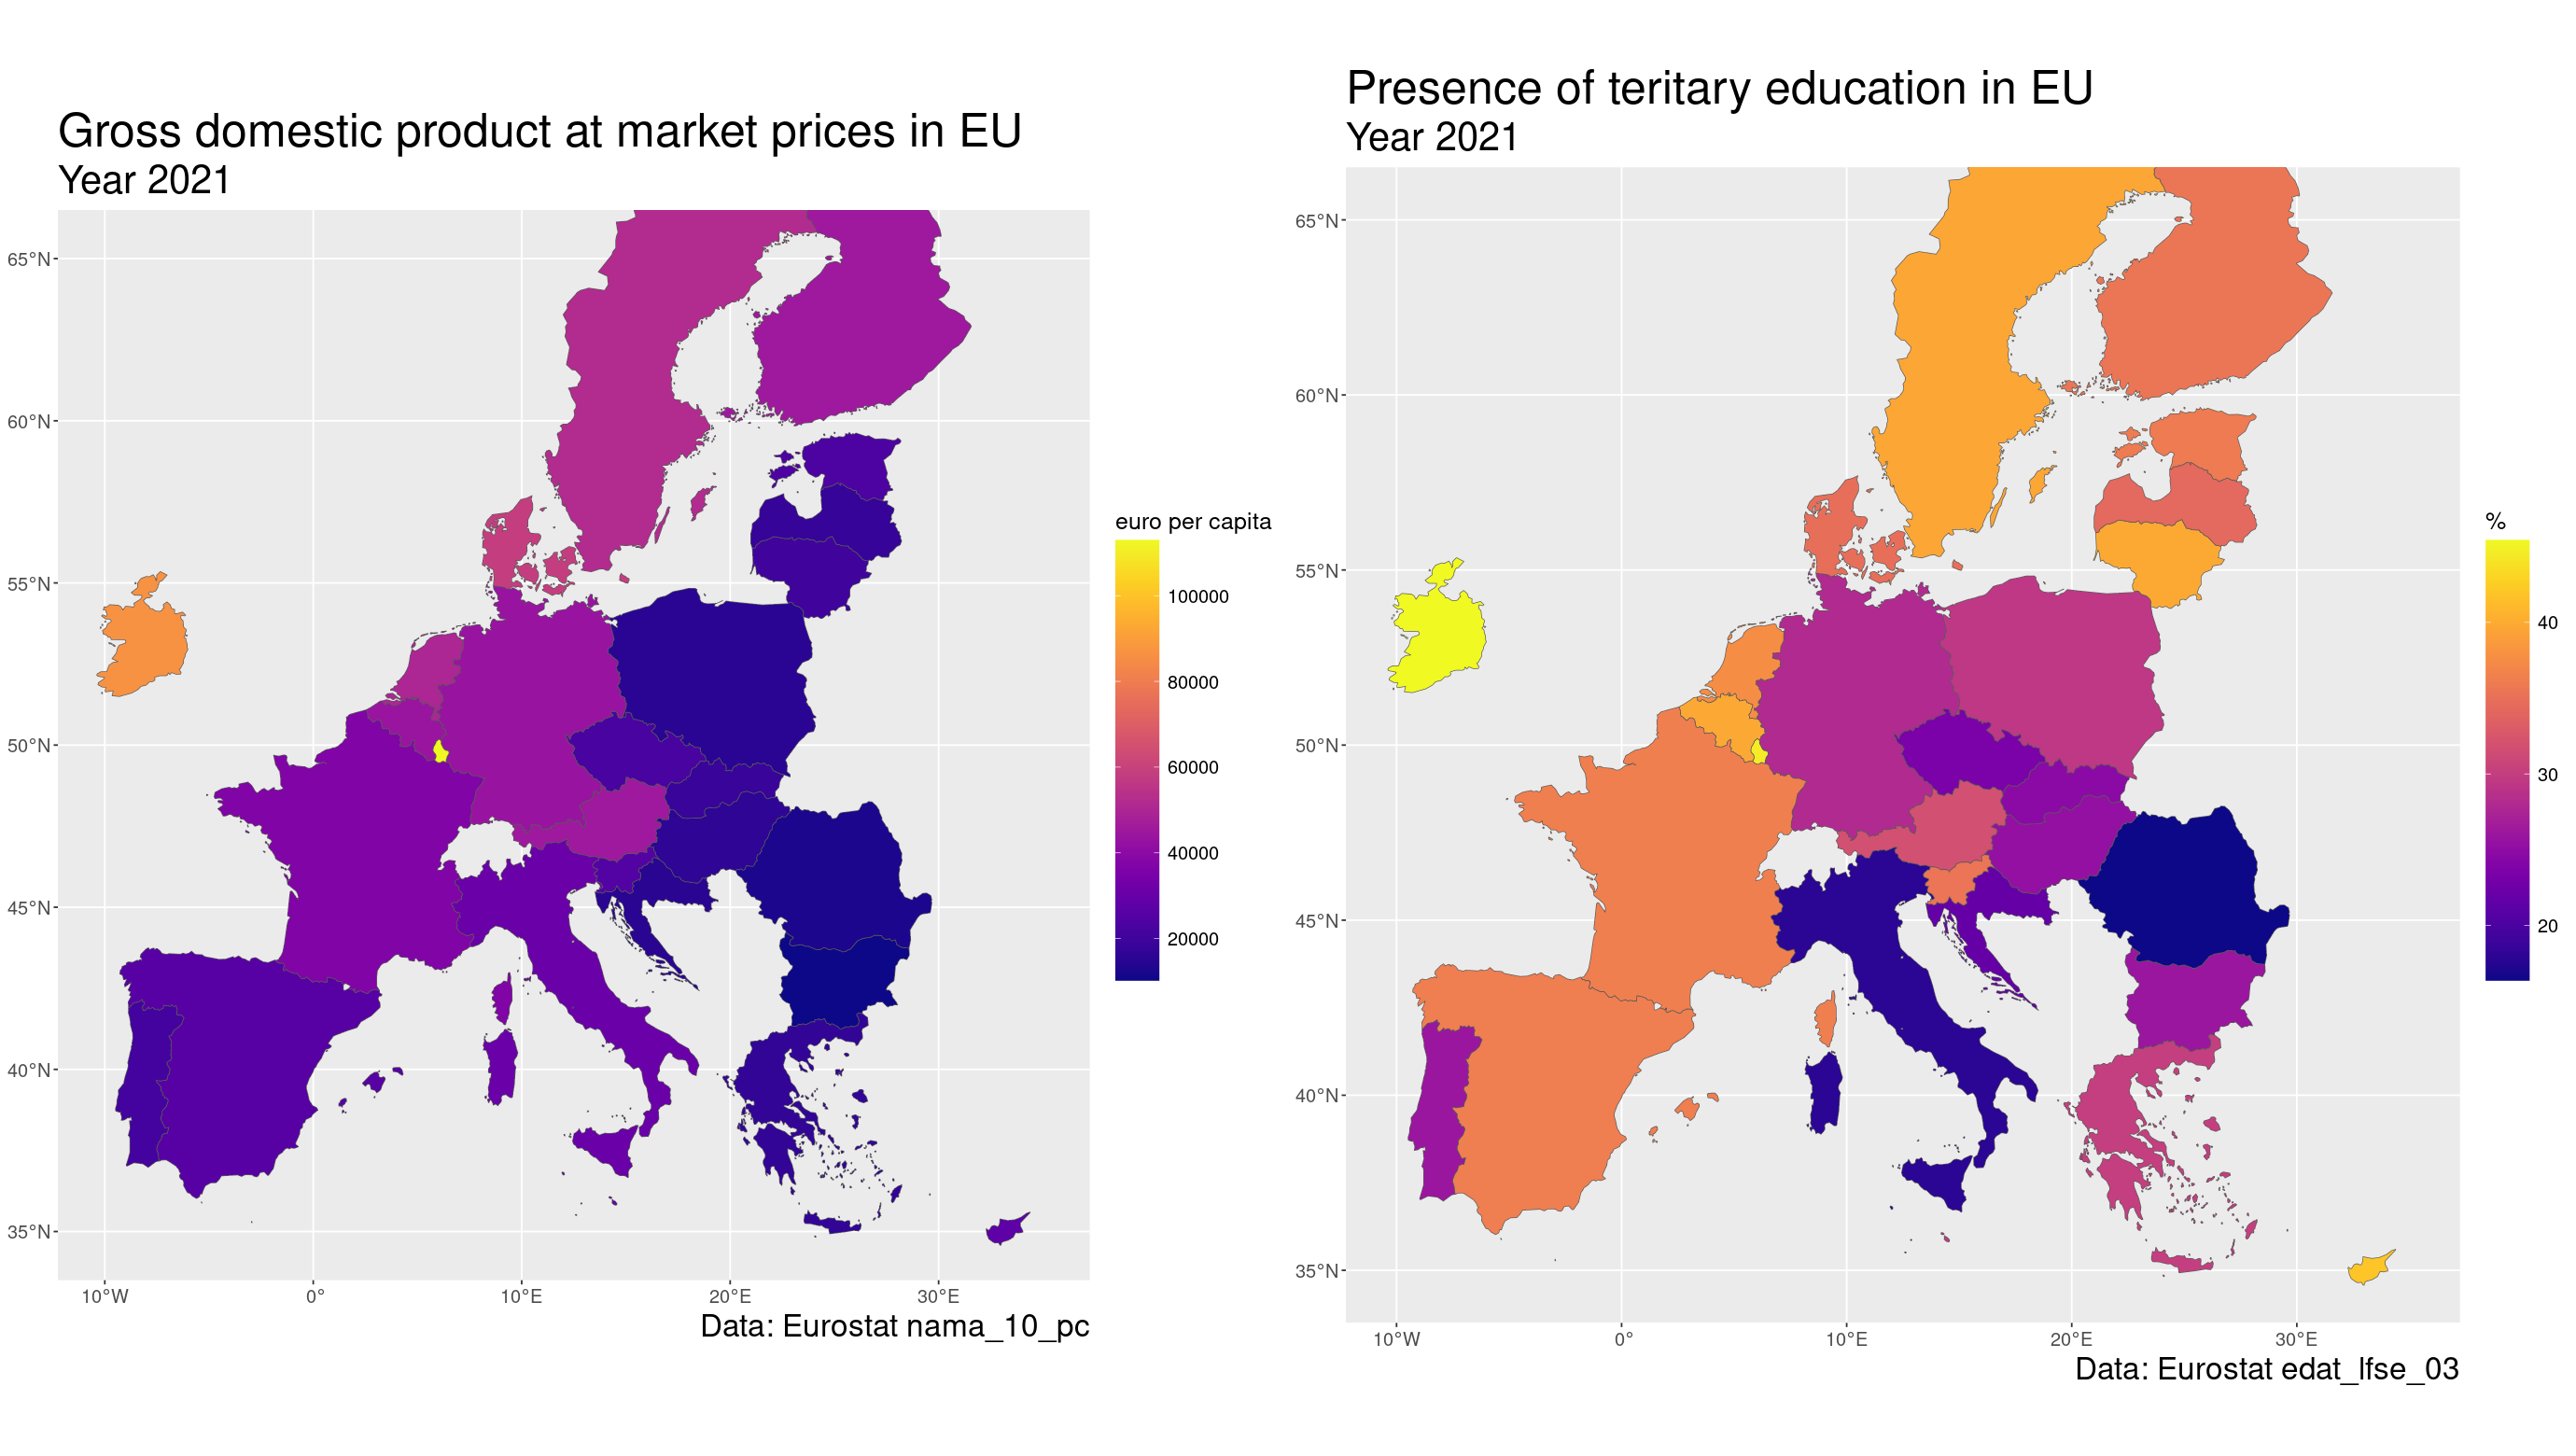

In [23]:
options(width=200, repr.plot.width=23, repr.plot.height=13);

df_tmp <- df %>% 
  inner_join(SHP_27, by = "geo") %>% 
  st_as_sf()

p1 <- df_tmp %>%
  ggplot(aes(fill = gdp)) +
  labs(
    title = "Gross domestic product at market prices in EU",
    subtitle = "Year 2021",
    caption = "Data: Eurostat nama_10_pc",
  ) +
  theme (
    plot.title = element_text(size = 30),
    plot.subtitle = element_text(size = 25),
    plot.caption = element_text(size = 20),
    text = element_text(size = 15)
  ) +
  geom_sf() +
  scale_fill_viridis (
    discrete = FALSE, 
    option = 'C',
    name = "euro per capita",
    breaks = seq(from = 0, to = 120000, by = 20000),
    guide = guide_colorbar (
      barwidth = unit(1, "cm"),
      barheight = unit(10, "cm"),  
    )
  ) +
  scale_x_continuous(limits = c(-10, 35)) +
  scale_y_continuous(limits = c(35, 65))


p2 <- df_tmp %>%
  ggplot(aes(fill = edu)) +
  labs(
    title = "Presence of teritary education in EU",
    subtitle = "Year 2021",
    caption = "Data: Eurostat edat_lfse_03",
  ) +
  theme (
    plot.title = element_text(size = 30),
    plot.subtitle = element_text(size = 25),
    plot.caption = element_text(size = 20),
    text = element_text(size = 15)
  ) +
  geom_sf() +
  scale_fill_viridis (
    discrete = FALSE, 
    option = 'C',
    name = "%",
    breaks = seq(from = 10, to = 50, by = 10),
    guide = guide_colorbar (
      barwidth = unit(1, "cm"),
      barheight = unit(10, "cm"),  
    )
  ) +
  scale_x_continuous(limits = c(-10, 35)) +
  scale_y_continuous(limits = c(35, 65))


ggarrange(p1, p2, ncol = 2, nrow = 1)

rm(df_tmp, p1, p2)

```

Exponential regression model with `GDP` ~ `Education level` + `exp^Education level` - `Intercept` formula.


Call:
lm(formula = gdp ~ edu + exp(edu) - 1, data = df)

Residuals:
   Min     1Q Median     3Q    Max 
-18892 -11961  -4344  11863  45060 

Coefficients:
          Estimate Std. Error t value Pr(>|t|)    
edu      9.744e+02  9.630e+01  10.118 2.53e-10 ***
exp(edu) 1.153e-15  2.934e-16   3.931 0.000591 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 15460 on 25 degrees of freedom
Multiple R-squared:  0.8694,	Adjusted R-squared:  0.859 
F-statistic: 83.23 on 2 and 25 DF,  p-value: 8.876e-12



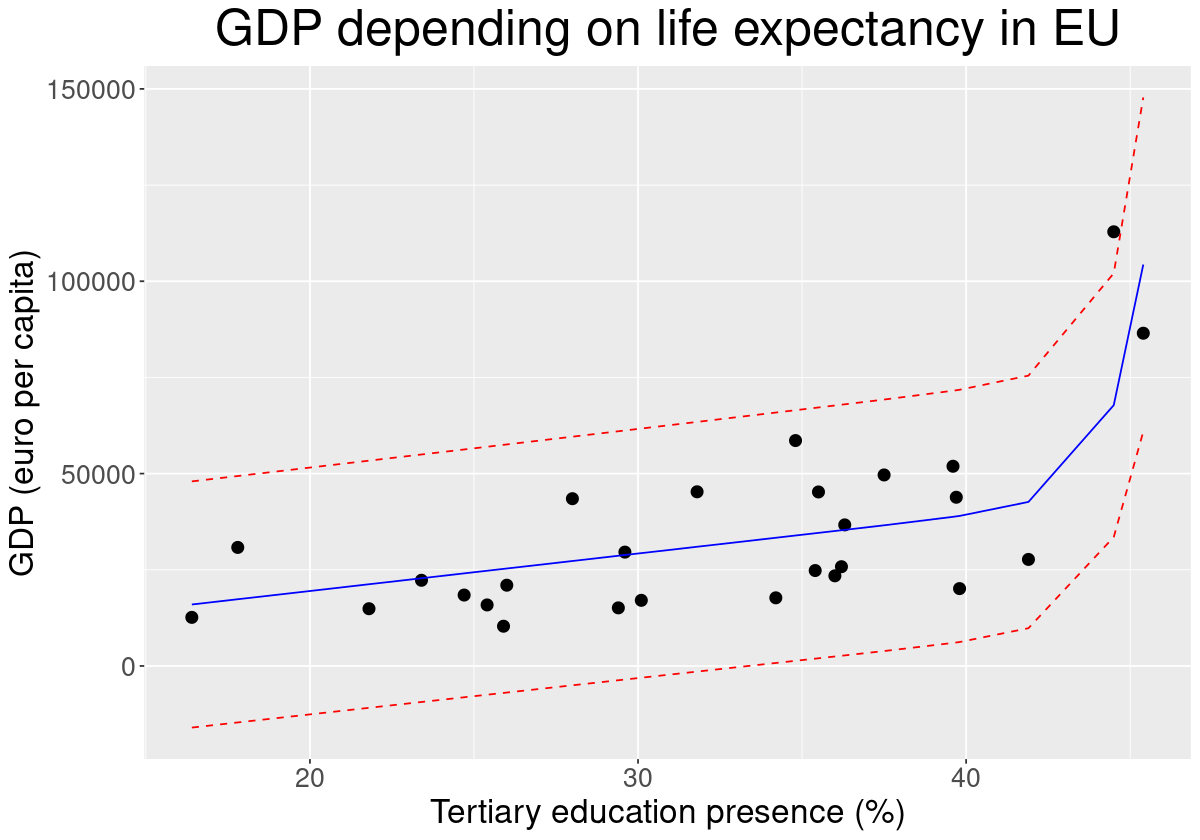

In [24]:
options(width=200, repr.plot.width=10, repr.plot.height=7);

# Fitting model
fit <- lm(formula = gdp ~ edu + exp(edu) - 1, data=df)
suppressWarnings({tmp <- predict(fit, interval="prediction")})
df_tmp <- cbind(df, tmp)

# Plotting main information about lm model
print(summary(fit))

# Plotting regression curve with confidential interval
ggplot(df_tmp, aes(y = gdp, x = edu)) +
xlab('Tertiary education presence (%)') + 
ylab('GDP (euro per capita)') + 
ggtitle('GDP depending on life expectancy in EU') + 
theme(plot.title = element_text(hjust = 0.5)) +
geom_point(size = 3) +
theme(
    text = element_text(size = 20),
    axis.title.x = element_text(size = 20),
    axis.title.y = element_text(size = 20),
    plot.title = element_text(size=30),
    ) +
geom_line(aes(y=fit), color="blue") +
geom_line(aes(y=lwr), color = "red", linetype = "dashed") +
geom_line(aes(y=upr), color = "red", linetype = "dashed")

rm(fit, df_tmp, tmp)

```

### Cold war division

As a categorical regressor, I decided to choose a historical factor, namely which **bloc** the country belonged to during **the Cold War**.

In [25]:
bloc <- read.csv('src/ussr.csv')

df <- merge(bloc, df, by = 'geo', )

rm(bloc)

```

Here is the dataset with 2 new `bloc` column.

In [26]:
df

geo,bloc,edu,life_expectancy,wage,name,gdp
<chr>,<lgl>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>
AT,FALSE,31.8,80.5,1500.00,Austria,45270
BE,FALSE,39.7,81.1,1625.72,Belgium,43850
BG,TRUE,25.9,70.8,332.34,Bulgaria,10330
CY,FALSE,41.9,80.5,1000.00,Cyprus,27690
CZ,TRUE,23.4,76.4,579.22,Czechia,22270
DE,FALSE,28.0,80.1,1585.00,Germany,43480
DK,FALSE,34.8,80.7,2230.00,Denmark,58590
EE,TRUE,36.0,76.3,584.00,Estonia,23430
EL,FALSE,30.1,79.4,758.33,Greece,17060


```

We can run **ANOVA** test, to check if difference between expected values for different blocs is statistical significant.

In [27]:
anova(aov(gdp ~ bloc, data=df))

,Df,Sum Sq,Mean Sq,F value,Pr(>F)
,<int>,<dbl>,<dbl>,<dbl>,<dbl>
bloc,1,3814945452,3814945452,9.106984,0.005785459
Residuals,25,10472582133,418903285,NA,NA


**p-value < 5 %**. Difference is statistically significant.

```

Visualizing `GDP` distribution depending on `bloc` value.

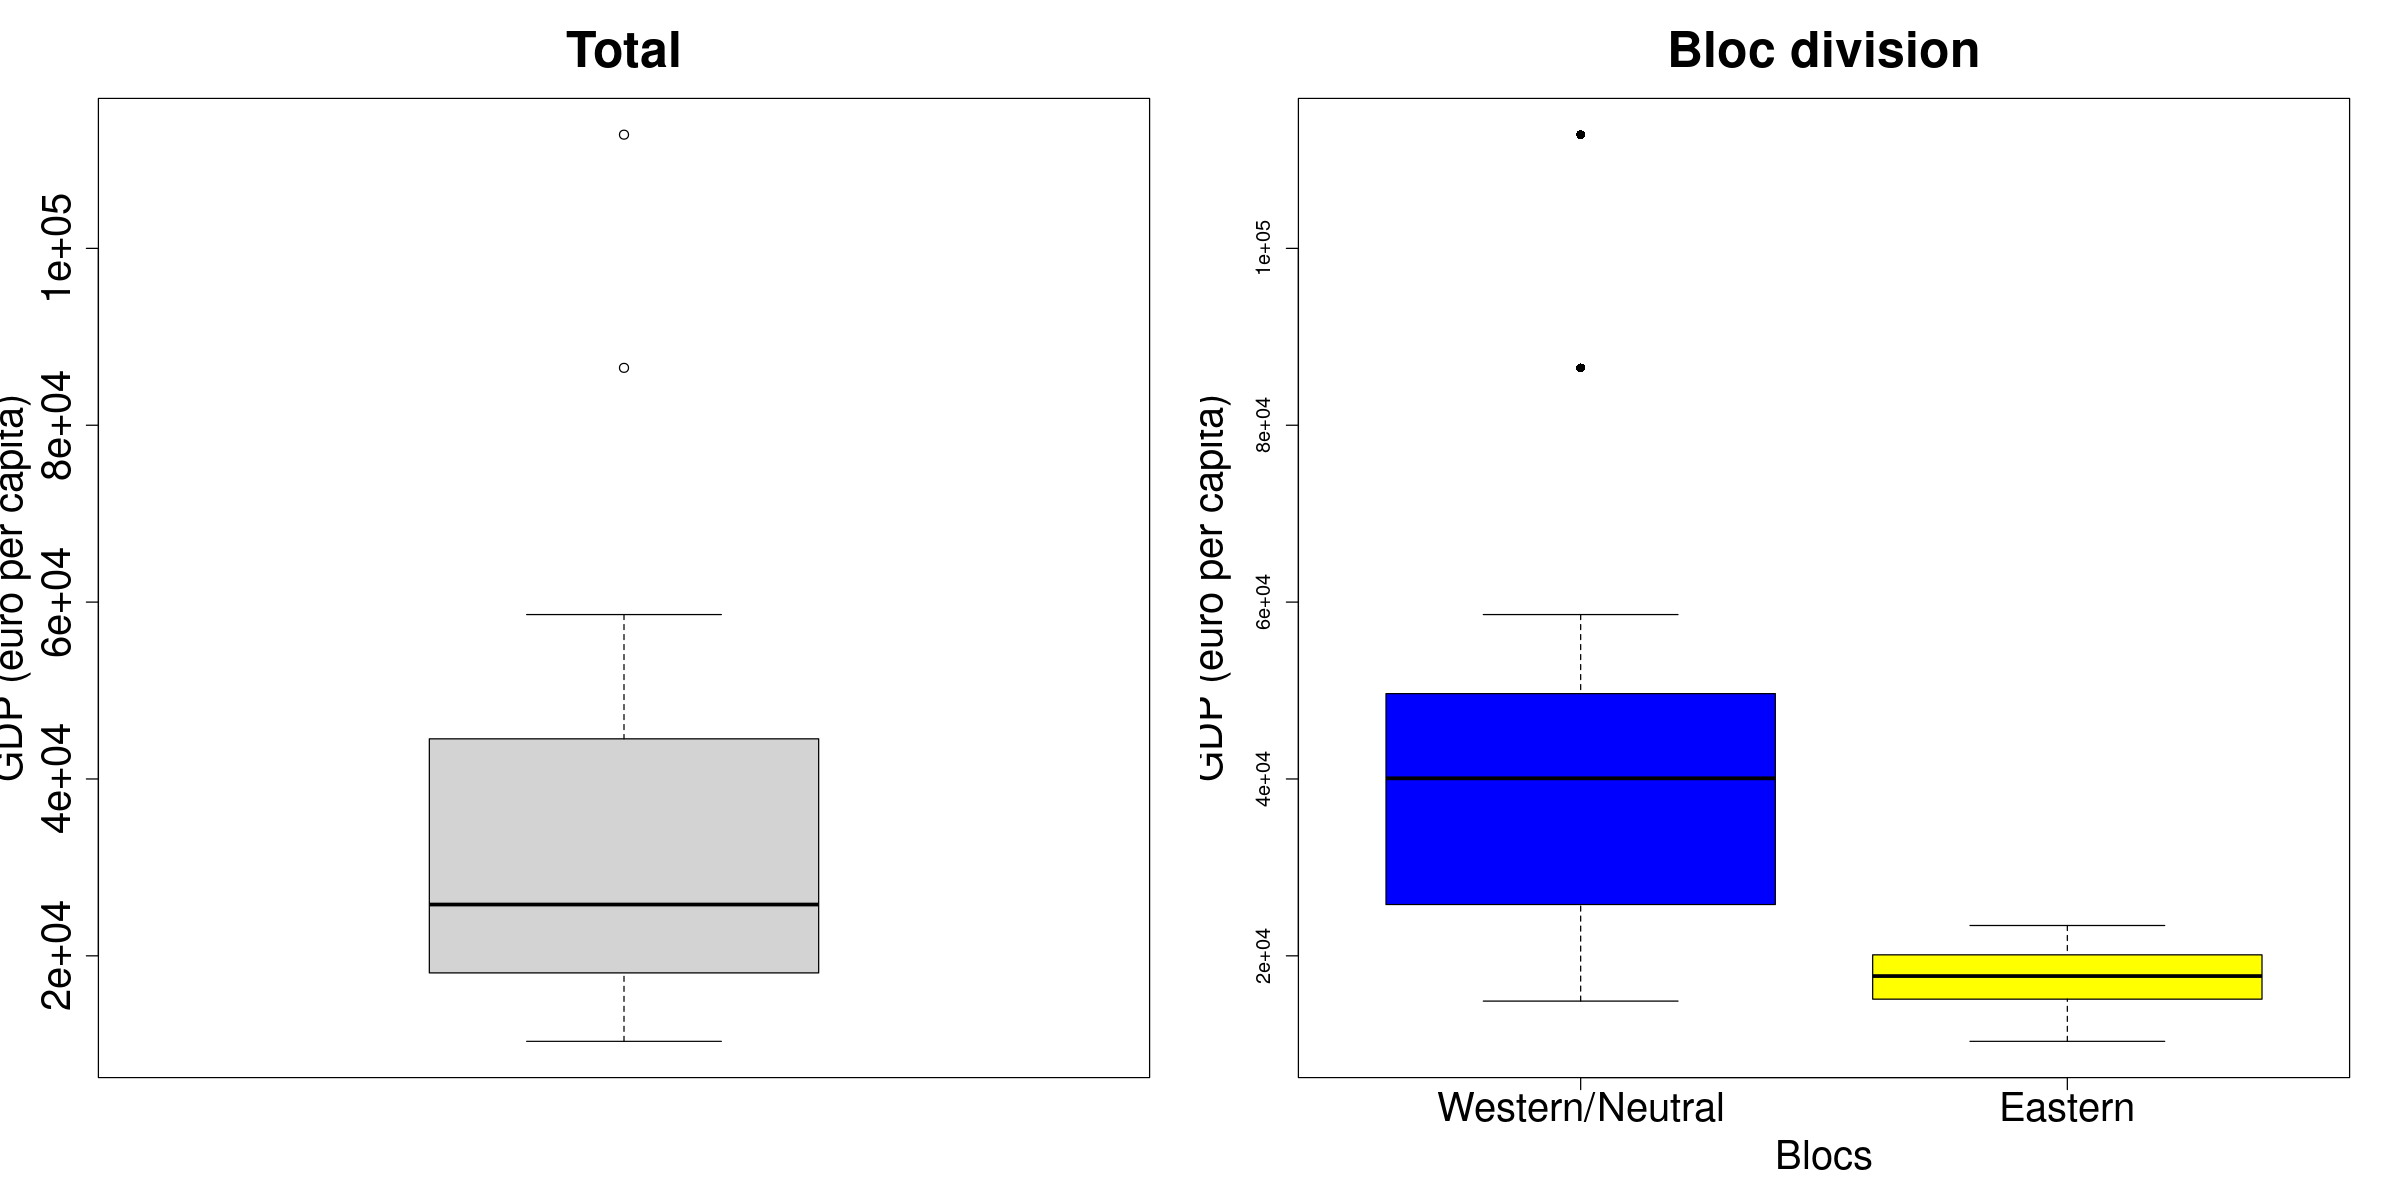

In [28]:
options(width=160, repr.plot.width=20, repr.plot.height=10)
colfunc <- colorRampPalette(c("blue", "yellow", "blue"))
plotly::layout(matrix(c(1,2), 1, 2, byrow = TRUE), )

boxplot(df$gdp,
        main = 'Total',
        cex.main = 2.5,
        cex.lab = 2,
        cex.axis = 2,
        xlab = '',
        ylab = 'GDP (euro per capita)'
        )

boxplot(data = df,
        gdp ~ bloc,
        col = colfunc(3),
        main = 'Bloc division',
        xaxt = "n",
        cex = 1,
        pch = 16,
        xlab = 'Blocs',
        ylab = 'GDP (euro per capita)',
        cex.lab = 2,
        cex.main = 2.5,
        cex.axis = 1
        )

axis(1, at = c(1, 2), labels = c("Western/Neutral","Eastern"), cex.axis = 2)

```

Visualizing maps.

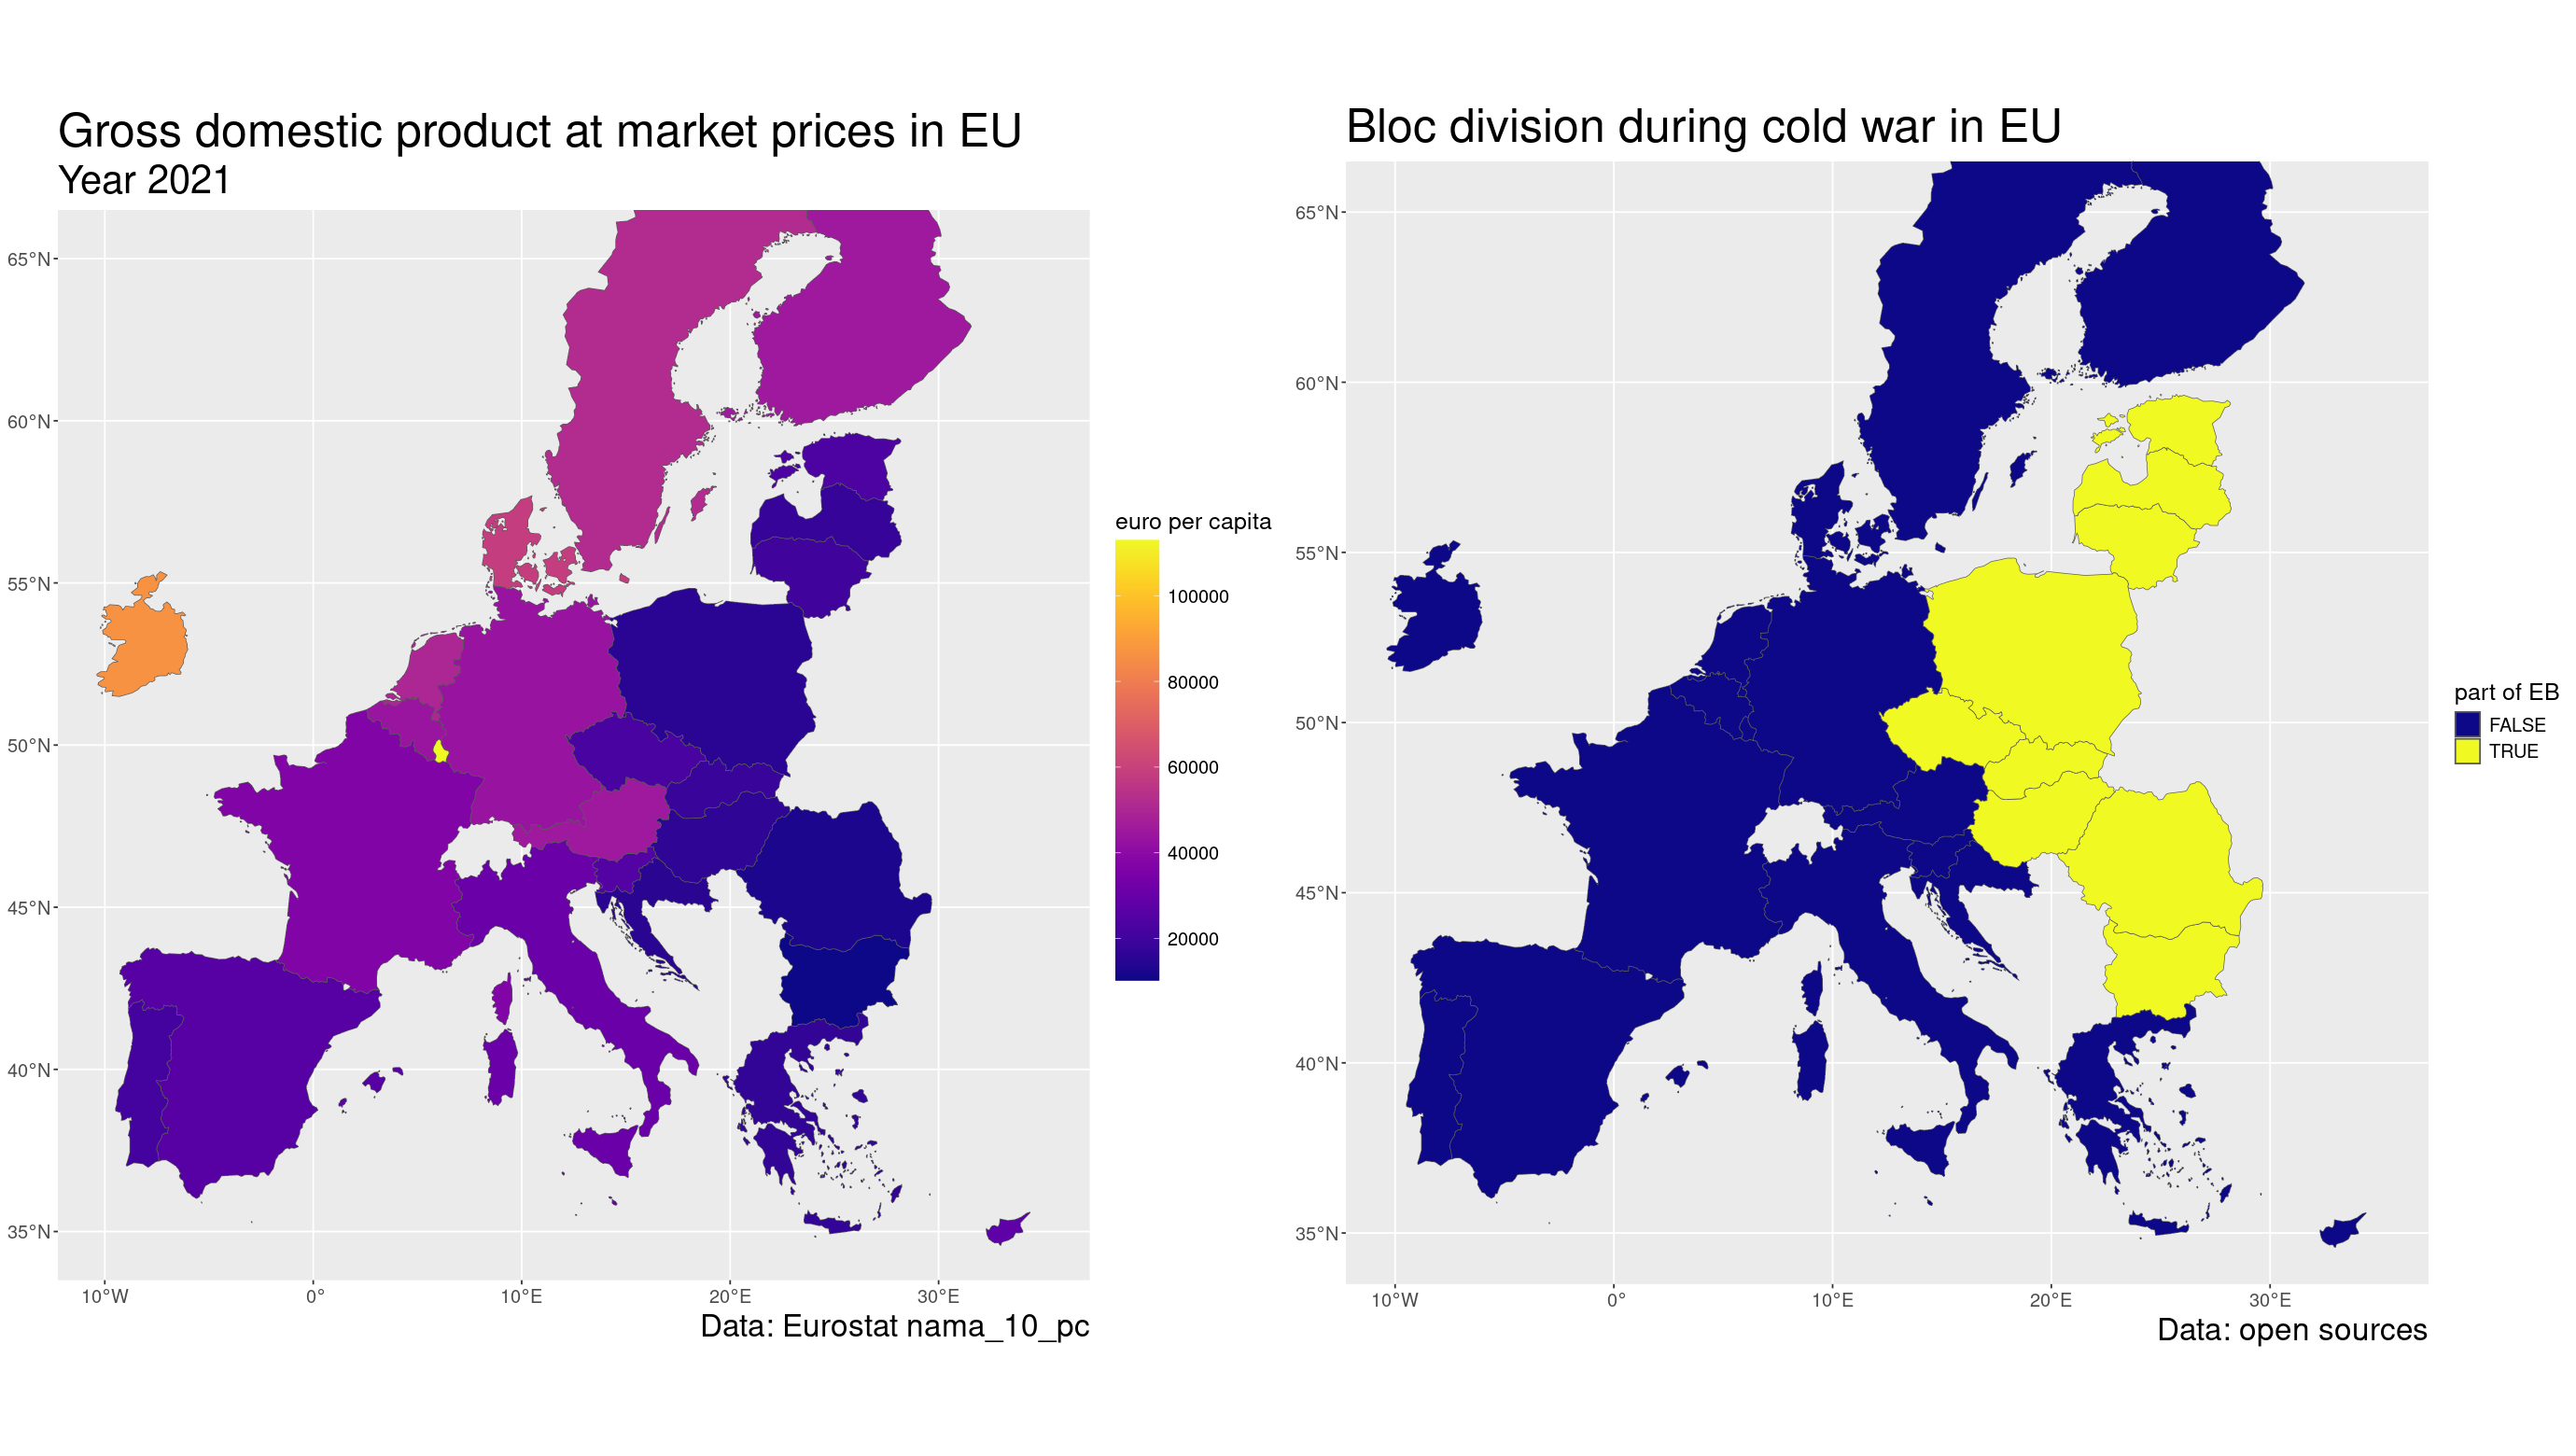

In [29]:
options(width=200, repr.plot.width=23, repr.plot.height=13);

df_tmp <- df %>% 
  inner_join(SHP_27, by = "geo") %>% 
  st_as_sf()

p1 <- df_tmp %>%
  ggplot(aes(fill = gdp)) +
  labs(
    title = "Gross domestic product at market prices in EU",
    subtitle = "Year 2021",
    caption = "Data: Eurostat nama_10_pc",
  ) +
  theme (
    plot.title = element_text(size = 30),
    plot.subtitle = element_text(size = 25),
    plot.caption = element_text(size = 20),
    text = element_text(size = 15)
  ) +
  geom_sf() +
  scale_fill_viridis (
    discrete = FALSE, 
    option = 'C',
    name = "euro per capita",
    breaks = seq(from = 0, to = 120000, by = 20000),
    guide = guide_colorbar (
      barwidth = unit(1, "cm"),
      barheight = unit(10, "cm"),  
    )
  ) +
  scale_x_continuous(limits = c(-10, 35)) +
  scale_y_continuous(limits = c(35, 65))


p2 <- df_tmp %>%
  ggplot(aes(fill = bloc)) +
  labs(
    title = "Bloc division during cold war in EU",
    caption = "Data: open sources",
  ) +
  theme (
    plot.title = element_text(size = 30),
    plot.subtitle = element_text(size = 25),
    plot.caption = element_text(size = 20),
    text = element_text(size = 15)
  ) +
  geom_sf() +
  scale_fill_viridis (
    discrete = TRUE, 
    option = 'C',
    name = "part of EB",
  ) +
  scale_x_continuous(limits = c(-10, 35)) +
  scale_y_continuous(limits = c(35, 65))


ggarrange(p1, p2, ncol = 2, nrow = 1)

rm(df_tmp, p1, p2)

```

Categorical linear regression model.

In [30]:
# Fitting model
fit <- lm(formula = gdp ~ bloc, data=df)

# Plotting main information about lm model
print(summary(fit))

rm(fit)


Call:
lm(formula = gdp ~ bloc, data = df)

Residuals:
   Min     1Q Median     3Q    Max 
-27654 -12334    391   3871  70326 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept)    42534       4824   8.817 3.82e-09 ***
blocTRUE      -25216       8356  -3.018  0.00579 ** 
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 20470 on 25 degrees of freedom
Multiple R-squared:  0.267,	Adjusted R-squared:  0.2377 
F-statistic: 9.107 on 1 and 25 DF,  p-value: 0.005785



```

N.B. 

In order to find good regressors I have also tested Interest rates, Inflation rates, Unemployent rates, Used currency, Fertility and Access to sea. None of them showed good results so I decided to not include them in final notebook.

---

# 3) Regression model

### Basic model

First model combines all regressors from the previus phase.

In [31]:
fit_base <- lm(gdp ~ bloc + I(wage^2) + edu + exp(edu) + I(life_expectancy^2), data=df)
summary(fit_base)


Call:
lm(formula = gdp ~ bloc + I(wage^2) + edu + exp(edu) + I(life_expectancy^2), 
    data = df)

Residuals:
     Min       1Q   Median       3Q      Max 
-12220.5  -1882.2    141.1   1947.0  22644.9 

Coefficients:
                       Estimate Std. Error t value Pr(>|t|)    
(Intercept)          -3.773e+04  3.789e+04  -0.996    0.331    
blocTRUE              8.161e+03  6.846e+03   1.192    0.247    
I(wage^2)             1.132e-02  1.393e-03   8.131 6.34e-08 ***
edu                   8.455e+01  2.314e+02   0.365    0.718    
exp(edu)              8.740e-16  1.449e-16   6.033 5.49e-06 ***
I(life_expectancy^2)  7.568e+00  6.052e+00   1.250    0.225    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 6937 on 21 degrees of freedom
Multiple R-squared:  0.9293,	Adjusted R-squared:  0.9124 
F-statistic: 55.18 on 5 and 21 DF,  p-value: 2.284e-11


Coefficients:
* `Intercept` - value **-37 730** means, that for a state, where all other regressors are equal to 0, we can predict **GDP** value as **-37 730**. $\\$
p-value > 5 %. **Failed to reject** the hypothesis, that the coeficient is not meaningful for the model.

* `blocTRUE` - value **8 161** means, that for a state, which **was a part of eastern bloc** during the cold war, we can expect, that **GDP** value will be higher. $\\$
p-value > 5 %. **Failed to reject** the hypothesis, that the coeficient is not meaningful for the model.

* `wage^2` - we can expect, that minimal wage increases **GDP** value by **0.011** * **EURO^2**. $\\$
p-value < 5 %. **Rejecting** the hypothesis, that the coeficient is not meaningful for the model.

* `edu` - we can expect, that each next **%** of people, who have succesfully completed teritary education level increases **GDP** value linearly by **86** . $\\$
p-value > 5 %. **Failed to reject** the hypothesis, that the coeficient is not meaningful for the model.

* `exp(edu) ` - we can expect, that percentage of people, who have succesfully completed teritary education level increases **GDP** value exponentially by **9e-16** * **exp(edu)**. $\\$
p-value < 5 %. **Rejecting** the hypothesis, that the coeficient is not meaningful for the model.

* `life_expectancy^2` - we can expect, that each next **year** in life expectancy increases **GDP** value by **7.6** * **year^2**. $\\$
p-value > 5 %. **Failed to reject** the hypothesis, that the coeficient is not meaningful for the model.

**Adjusted R-squared** -  0.910. The model has a strong ability to predict `GDP` behavior.

However, the model still contains some statisticaly insignificant parts, that may be removed.

```

### Better Model

To find better model between all possible combinations I decided to use **step()** function, that uses greedy approach to find model with the best Akaike Information Criterion.

Starting model - empty model (`GDP` ~ `Intercept`)

Upper boundary model - maximum model (`GDP` = `Block` + `Minumum wage^2` + `Life expectancy^2` + `exp(Education)`)

(N.B. I decided to not use interractions, as it leads to strong overfitting.)

In [150]:
fit_better = step(lm(gdp ~ 1, data=df),                                            # Empty formula
                    scope=list
                    (
                        lower=~1,                                                  # Empty formula
                        upper=~bloc + I(wage^2) + exp(edu) + I(life_expectancy^2)  # Formula with all possible interractions
                    )
                )

Start:  AIC=544.34
gdp ~ 1

                       Df  Sum of Sq        RSS    AIC
+ I(wage^2)             1 1.1078e+10 3.2092e+09 506.02
+ exp(edu)              1 6.5148e+09 7.7727e+09 529.91
+ I(life_expectancy^2)  1 5.2408e+09 9.0468e+09 534.01
+ bloc                  1 3.8149e+09 1.0473e+10 537.96
<none>                               1.4288e+10 544.34

Step:  AIC=506.02
gdp ~ I(wage^2)

                       Df  Sum of Sq        RSS    AIC
+ exp(edu)              1 2.1001e+09 1.1092e+09 479.34
<none>                               3.2092e+09 506.02
+ bloc                  1 1.4083e+07 3.1952e+09 507.90
+ I(life_expectancy^2)  1 1.1145e+07 3.1981e+09 507.93
- I(wage^2)             1 1.1078e+10 1.4288e+10 544.34

Step:  AIC=479.34
gdp ~ I(wage^2) + exp(edu)

                       Df  Sum of Sq        RSS    AIC
<none>                               1109162438 479.34
+ I(life_expectancy^2)  1   13647585 1095514853 481.00
+ bloc                  1    2567527 1106594911 481.28
- exp(edu

```

Running **ANOVA** test, to check if the new model is not statisticaly different from the base model.

In [142]:
anova(fit_better, fit_base, test="F")

,Res.Df,RSS,Df,Sum of Sq,F,Pr(>F)
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,24,1109162438,NA,NA,NA,NA
2,21,1010612211,3,98550227,0.6826076,0.5725543


**p-value** > 5 %. **Failed to reject** the hypothesis, that the difference between old and new models is not statistically significant.

```

Model found by **step()** is `GDP` ~ `Minumum wage^2` + `exp(Education level)`.

In [143]:
summary(fit_better)


Call:
lm(formula = gdp ~ I(wage^2) + exp(edu), data = df)

Residuals:
     Min       1Q   Median       3Q      Max 
-13803.0  -3065.7     33.6   1594.4  22794.5 

Coefficients:
             Estimate Std. Error t value Pr(>|t|)    
(Intercept) 1.351e+04  1.928e+03   7.008 3.02e-07 ***
I(wage^2)   1.184e-02  9.861e-04  12.008 1.23e-11 ***
exp(edu)    9.036e-16  1.340e-16   6.741 5.68e-07 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 6798 on 24 degrees of freedom
Multiple R-squared:  0.9224,	Adjusted R-squared:  0.9159 
F-statistic: 142.6 on 2 and 24 DF,  p-value: 4.791e-14


Coeficients:
* `Intercept` - value **13 510** means, that for a state, where **minimum wage** and **percentage of population that have completed tritatry education** are equal to 0, we can predict **GDP** value as **13 510**. $\\$
p-value < 5 %. **Rejecting** the hypothesis, that the coeficient is not meaningful for the model.

* `wage^2` - we can expect, that minimal wage increases **GDP** value by **0.012** * **EURO^2**. $\\$
p-value < 5 %. **Rejecting** the hypothesis, that the coeficient is not meaningful for the model.

* `exp(edu) ` - we can expect, that percentage of people, who have succesfully completed teritary education level increases **GDP** value exponentially by **9e-16** * **exp(edu)**.$\\$
p-value < 5 %. **Rejecting** the hypothesis, that the coeficient is not meaningful for the model.

**Adjusted R-squared** -  0.916. The model has a strong ability to predict `GDP` behavior.

```

Residual analysis.

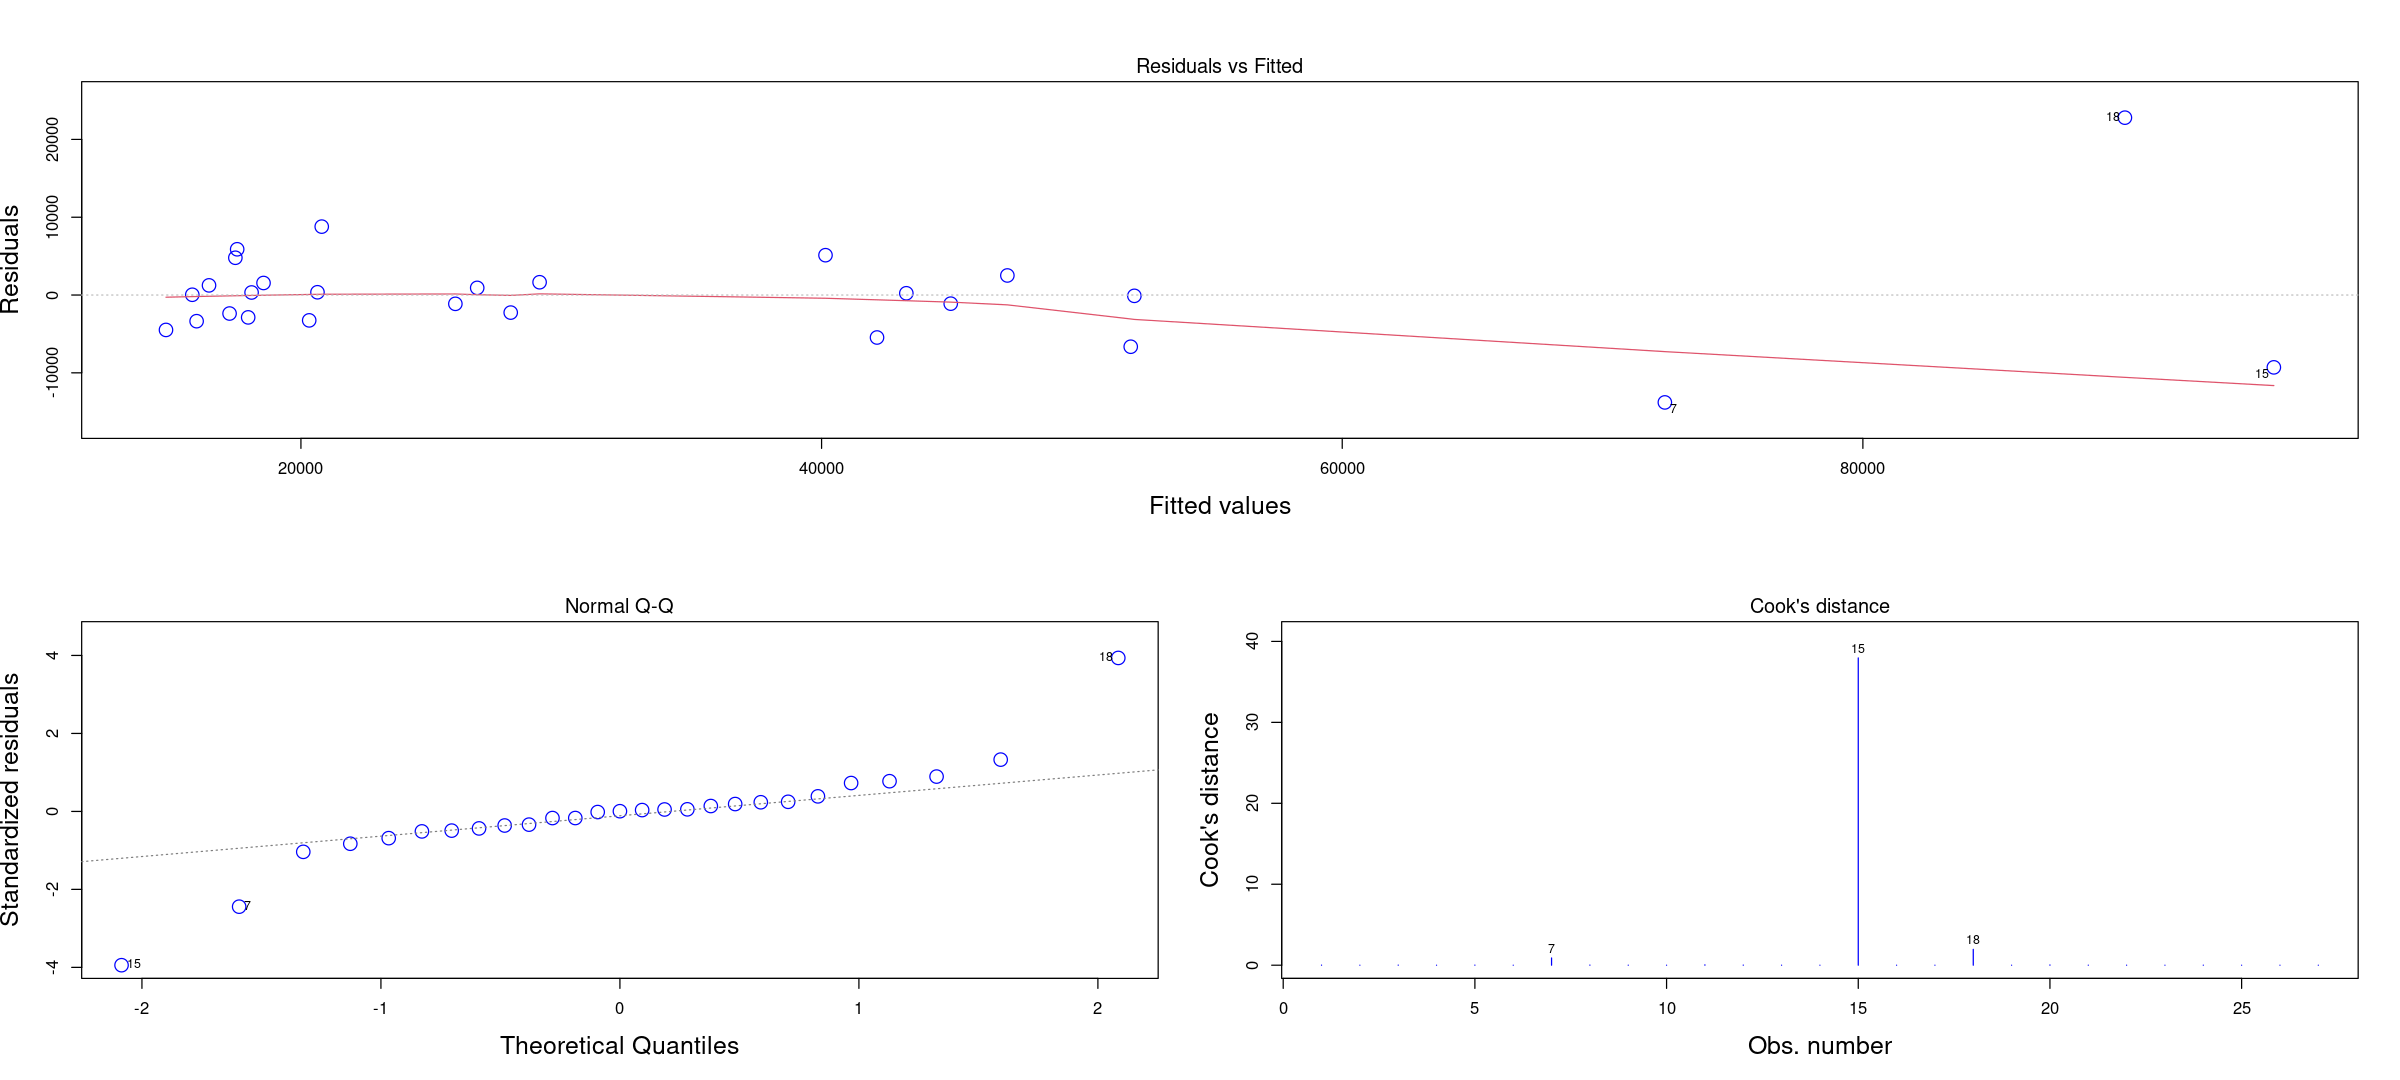

In [144]:
options(width=160, repr.plot.width=20, repr.plot.height=9)   
plotly::layout(matrix(c(1,1,2,3), 2, 2, byrow = TRUE), )
plot(fit_better, which=1, col=c("blue"), cex = 1.8, cex.lab = 1.5)
plot(fit_better, which=2, col=c("blue"), cex = 1.8, cex.lab = 1.5)
plot(fit_better, which=4, col=c("blue"), cex = 1.8, cex.lab = 1.5)

Most residuals almost follow **normal** pattern. $\\$
In 50% cases residuals lay in **(-3000, 1600)** interval.$\\$
Dataset has 3 crucial outliers: 7 (Denmark), 15 (Ireland) and 18 (Luxembourg).

```

Reziduals normality and homoscedasticity tests.

In [164]:
bptest(fit_better)
shapiro.test(fit_better$resid)


	studentized Breusch-Pagan test

data:  fit_better
BP = 11.674, df = 2, p-value = 0.002918



	Shapiro-Wilk normality test

data:  fit_better$resid
W = 0.88354, p-value = 0.005734


**p-values** < 5%. Rejecting both homoscedasticiy and normality of reziduals.

```

Using boxcox() function to find the best $\lambda$ for boxcox transformation.

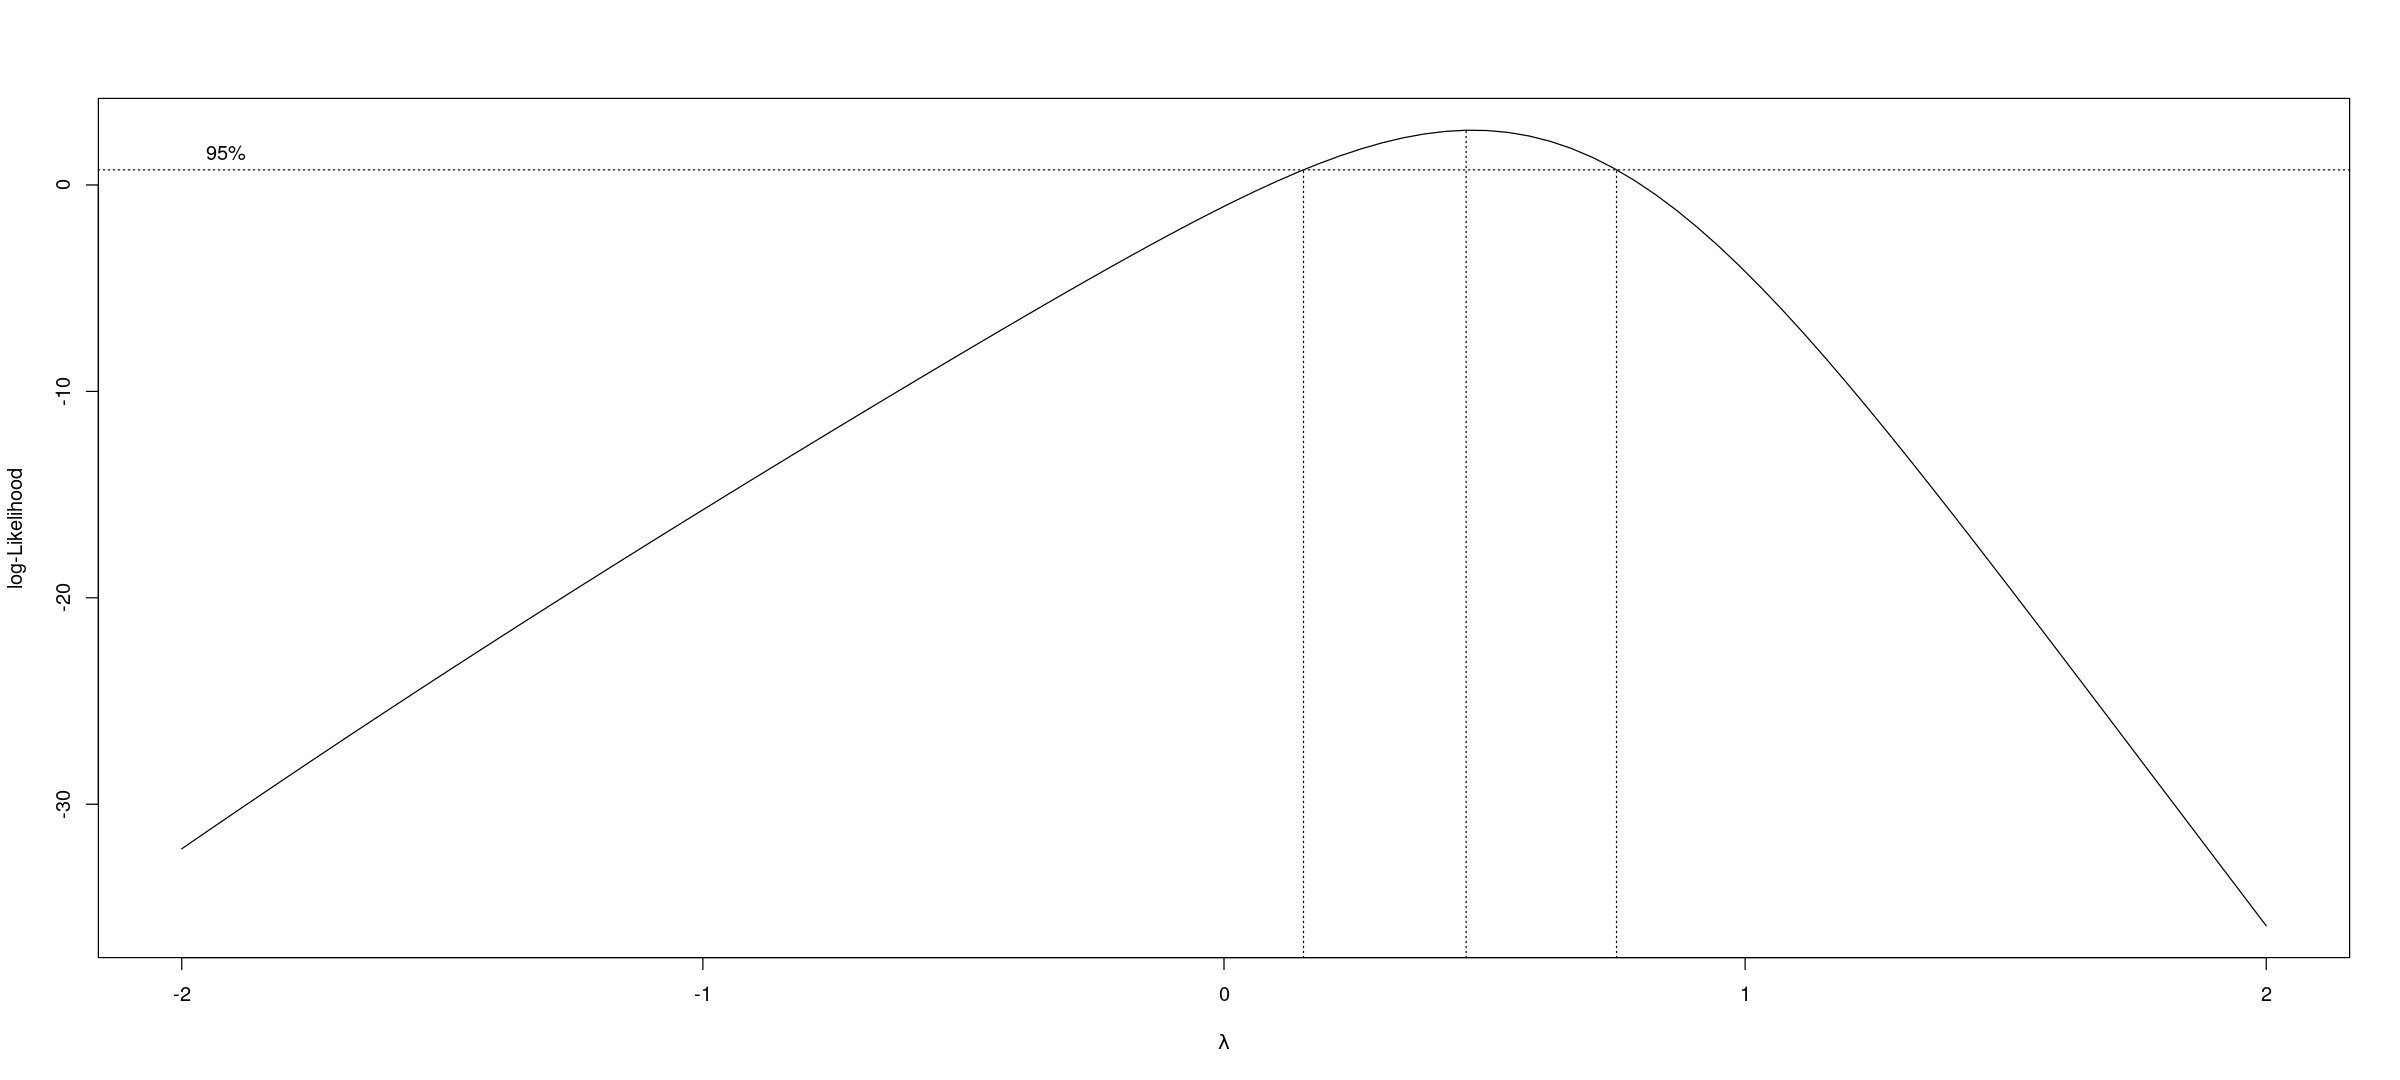

In [168]:
df_tmp <- df
boxcox(lm(formula = gdp ~ I(wage^2) + exp(edu), data = df_tmp))
rm(df_tmp)

Due to the formula of Box-Cox transformation, for $\lambda$ = 0.5 we can use

$$\frac{Y^{0.5}-1}{0.5} = \text{wage}^2 + e^\text{edu}$$

However, we can simplify that:

$${Y^{0.5}-1} = \frac{1}{2}(\text{wage}^2 + e^\text{edu})$$
$${Y^{0.5}} = \frac{1}{2}(\text{wage}^2 + e^\text{edu} + 2)$$
$${Y} = \frac{1}{4}(\text{wage}^2 + e^\text{edu} + 2)^2$$

Which can be approximately achieved by adding extra combinations of **wage** and **edu** to original model.

In [185]:
fit_final = step(lm(gdp ~ 1, data=df),
                    scope=list
                    (
                        lower=~1,
                        upper=~I(wage^2) * exp(edu) * edu * wage # new edu and wage interractions
                    )
                )

Start:  AIC=544.34
gdp ~ 1

            Df  Sum of Sq        RSS    AIC
+ I(wage^2)  1 1.1078e+10 3.2092e+09 506.02
+ wage       1 1.0563e+10 3.7245e+09 510.04
+ exp(edu)   1 6.5148e+09 7.7727e+09 529.91
+ edu        1 5.6858e+09 8.6018e+09 532.64
<none>                    1.4288e+10 544.34

Step:  AIC=506.02
gdp ~ I(wage^2)

            Df  Sum of Sq        RSS    AIC
+ exp(edu)   1 2.1001e+09 1.1092e+09 479.34
+ edu        1 3.6799e+08 2.8412e+09 504.74
<none>                    3.2092e+09 506.02
+ wage       1 1.1491e+07 3.1977e+09 507.93
- I(wage^2)  1 1.1078e+10 1.4288e+10 544.34

Step:  AIC=479.34
gdp ~ I(wage^2) + exp(edu)

                     Df  Sum of Sq        RSS    AIC
+ I(wage^2):exp(edu)  1  704634882  404527556 454.10
<none>                             1109162438 479.34
+ edu                 1   20449180 1088713258 480.84
+ wage                1    3583422 1105579015 481.25
- exp(edu)            1 2100071823 3209234261 506.02
- I(wage^2)           1 6663562203 77727246

```

In [186]:
summary(fit_final)


Call:
lm(formula = gdp ~ I(wage^2) + exp(edu) + wage + I(wage^2):exp(edu), 
    data = df)

Residuals:
    Min      1Q  Median      3Q     Max 
-5170.1 -2484.2  -113.9  1617.1  6939.1 

Coefficients:
                     Estimate Std. Error t value Pr(>|t|)    
(Intercept)         4.882e+03  3.693e+03   1.322  0.19982    
I(wage^2)           1.465e-03  3.045e-03   0.481  0.63524    
exp(edu)           -1.993e-15  3.758e-16  -5.302 2.54e-05 ***
wage                2.150e+01  7.336e+00   2.930  0.00775 ** 
I(wage^2):exp(edu)  9.309e-22  1.186e-22   7.848 8.11e-08 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 3637 on 22 degrees of freedom
Multiple R-squared:  0.9796,	Adjusted R-squared:  0.9759 
F-statistic: 264.6 on 4 and 22 DF,  p-value: < 2.2e-16


```

`Minumum wage^2` became statistically insignificant, so we can remove it.

In [200]:
fit_final <- lm(formula = gdp ~ exp(edu) + wage + I(wage^2):exp(edu), data = df)

```

Applying tests again.

In [201]:
bptest(fit_final1)
shapiro.test(fit_final1$resid)


	studentized Breusch-Pagan test

data:  fit_final1
BP = 1.7057, df = 3, p-value = 0.6357



	Shapiro-Wilk normality test

data:  fit_final1$resid
W = 0.96908, p-value = 0.5777


```

Now reziduals follow normal pattern and homoscedasticity.

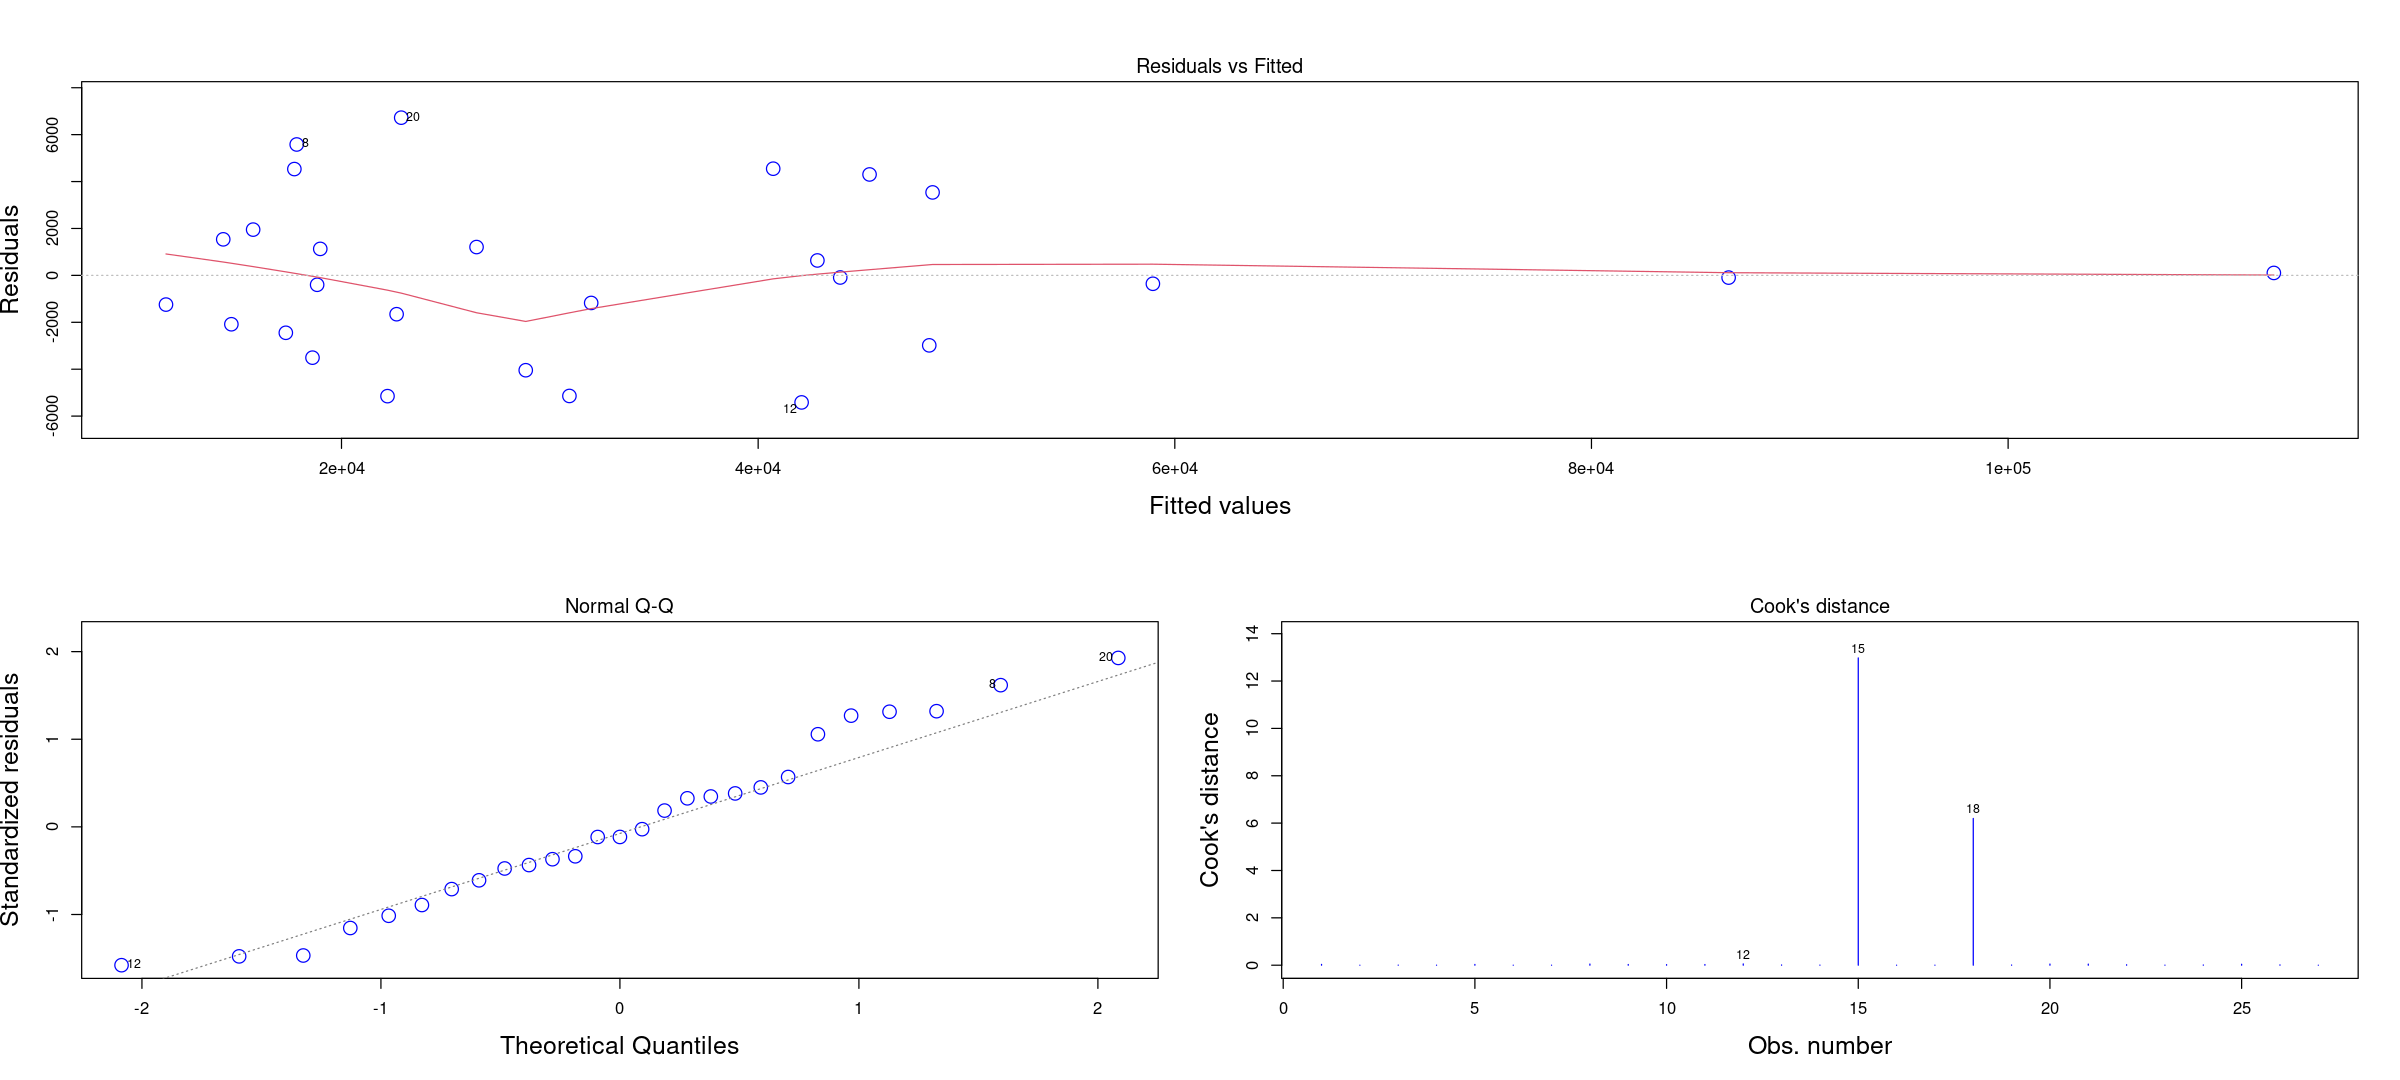

In [197]:
options(width=160, repr.plot.width=20, repr.plot.height=9)   
plotly::layout(matrix(c(1,1,2,3), 2, 2, byrow = TRUE), )
plot(fit_final, which=1, col=c("blue"), cex = 1.8, cex.lab = 1.5)
plot(fit_final, which=2, col=c("blue"), cex = 1.8, cex.lab = 1.5)
plot(fit_final, which=4, col=c("blue"), cex = 1.8, cex.lab = 1.5)

```

Multicollinearity

In [203]:
cor(model.matrix(fit_final))

Warning message in cor(model.matrix(fit_final)):
“the standard deviation is zero”


,(Intercept),exp(edu),wage,exp(edu):I(wage^2)
(Intercept),1,NA,NA,NA
exp(edu),NA,1.0000000,0.3487817,0.9785439
wage,NA,0.3487817,1.0000000,0.3990187
exp(edu):I(wage^2),NA,0.9785439,0.3990187,1.0000000


```

Variance Inflation Factor

In [204]:
data.frame(vif(fit_final))

there are higher-order terms (interactions) in this model
consider setting type = 'predictor'; see ?vif



,vif.fit_final.
,<dbl>
exp(edu),24.761058
wage,1.250202
exp(edu):I(wage^2),25.867411


```

**exp(edu)** or **exp(edu):I(wage^2)** may be removed, as they have **VIF** > 5.

In [211]:
fit_final <- lm(formula = gdp ~ wage + I(wage^2):exp(edu), data = df)

In [212]:
summary(fit_final)


Call:
lm(formula = gdp ~ wage + I(wage^2):exp(edu), data = df)

Residuals:
   Min     1Q Median     3Q    Max 
-12230  -2817  -1141   2661  18450 

Coefficients:
                    Estimate Std. Error t value Pr(>|t|)    
(Intercept)        1.468e+03  2.504e+03   0.586    0.563    
wage               2.686e+01  2.145e+00  12.521 5.16e-12 ***
I(wage^2):exp(edu) 3.290e-22  3.538e-23   9.300 1.99e-09 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 5806 on 24 degrees of freedom
Multiple R-squared:  0.9434,	Adjusted R-squared:  0.9387 
F-statistic: 199.9 on 2 and 24 DF,  p-value: 1.086e-15


```

**Intercept** is not statistically significant for the final model.

In [214]:
fit_final <- lm(formula = gdp ~ wage + I(wage^2):exp(edu) - 1, data = df)

```

Here is the final model.

In [215]:
summary(fit_final)


Call:
lm(formula = gdp ~ wage + I(wage^2):exp(edu) - 1, data = df)

Residuals:
     Min       1Q   Median       3Q      Max 
-11915.6  -2933.5   -711.6   2908.3  17973.7 

Coefficients:
                    Estimate Std. Error t value Pr(>|t|)    
wage               2.797e+01  9.808e-01   28.52  < 2e-16 ***
I(wage^2):exp(edu) 3.241e-22  3.390e-23    9.56 7.89e-10 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 5729 on 25 degrees of freedom
Multiple R-squared:  0.9821,	Adjusted R-squared:  0.9806 
F-statistic: 684.2 on 2 and 25 DF,  p-value: < 2.2e-16


Coefficients:

* `wage` - we can expect, that each **EURO** in minimal wage increases **GDP** value by **28**. $\\$
p-value < 5 %. **Rejecting** the hypothesis, that the coeficient is not meaningful for the model.

* `I(wage^2):exp(edu)` - we can expect, that each **%** of people, who have succesfully completed teritary education level and each **EURO** in minimal wage increase **GDP** value by **3e-22** * **exp(edu)** * **wage^2**. $\\$
p-value < 5 %. **Rejecting** the hypothesis, that the coeficient is not meaningful for the model.

---